# Final propagation step to wave breaking

All the data could be propagated to the surfbreak, but we still do not know how waves break, as we do not know their significant wave height at break ($H_B$). With this purpose, we proportionate a method to calculate the slope of the beaches, in case we are talking about a beachbreak, so the way waves break and their height can be calculated.

This method uses the law of snell first to propagate waves to the shore and then, knowing the waves that reach the beach, we can estimate the slope that sees the wave when breaking.

This methodology is explained in the figure below (Javier Tausia, 2020), and running the notebook, it will be more clear.

![break](../images/slopes/rotura.png)

In [1]:
# common 
import sys
import os
import os.path as op

# basic 
import xarray as xr
import numpy as np
import pandas as pd
from datetime import timedelta as td
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters

# dev library 
sys.path.insert(0, os.getcwd())

# RBF module 
from slopes import Slopes

In [2]:
def wf_calc(A, B):
    d50 = np.exp((0.5 - A)/B)
    wf = 233 * ((d50/1000) ** 1.1)
    print('The values of D50 and wf are, respectively: {}, {}'.format(d50, wf))
    return wf


def index(waves):
    
    # We first generate the empy lists
    index = []
    index_hb = []
    index_tp = []
    index_spr = []
    index_iri = []
    index_ddir = []
    index_ddirw = []
    
    # hours, months and years
    waves_month = []
    waves_hour = []
    waves_season = []
    waves_day_moment = []
    waves_year = []
    
    # We now save the grades
    for i in range(len(waves)):
        if (i%20000)==0:
            print('\n {} waves computed...'.format(i))
        # Compute ihb
        if waves['H_break'][i]<(0.5*1.7):
            ihb = 0
        elif waves['H_break'][i]<(0.7*1.7):
            ihb = 3
        elif waves['H_break'][i]<(1.0*1.7):
            ihb = 7
        elif waves['H_break'][i]<(1.5*1.7):
            ihb = 10
        elif waves['H_break'][i]<(1.8*1.7):
            ihb = 8
        elif waves['H_break'][i]<(2.2*1.7):
            ihb = 5
        elif waves['H_break'][i]<(2.6*1.7):
            ihb = 3
        else:
            ihb = 0
        # Compute itp
        if waves['Tp'][i]<6:
            itp = 0
        elif waves['Tp'][i]<8:
            itp = 3
        elif waves['Tp'][i]<10:
            itp = 5
        elif waves['Tp'][i]<12:
            itp = 7
        elif waves['Tp'][i]<14:
            itp = 9
        else:
            itp = 10
        # Compute ispr
        if waves['Spr'][i]<12:
            ispr = 10
        elif waves['Spr'][i]<15:
            ispr = 9
        elif waves['Spr'][i]<18:
            ispr = 8
        elif waves['Spr'][i]<22:
            ispr = 6
        elif waves['Spr'][i]<26:
            ispr = 4
        else:
            ispr = 2
        # Compute iir
        if waves['Iribarren'][i]<0.3:
            iir = 0
        elif waves['Iribarren'][i]<0.6:
            iir = 3
        elif waves['Iribarren'][i]<0.9:
            iir = 6
        elif waves['Iribarren'][i]<1.2:
            iir = 8
        elif waves['Iribarren'][i]<1.6:
            iir = 10
        elif waves['Iribarren'][i]<1.9:
            iir = 6
        elif waves['Iribarren'][i]<2.2:
            iir = 3
        else:
            iir = 0
        # Compute idd
        if abs(waves['DDir_R'][i])<(20*np.pi/180):
            idd = 0.8
        elif abs(waves['DDir_R'][i])<(30*np.pi/180):
            idd = 1.0
        elif abs(waves['DDir_R'][i])<(50*np.pi/180):
            idd = 1.1
        else:
            idd = 1.2
        # Compute iw
        if abs(waves['DDir_R'][i] - waves['DDirW'][i])<(25*np.pi/180):
            if waves['W'][i]<7:
                iw = 0.8
            elif waves['W'][i]<14:
                iw = 0.5
            else:
                iw = 0.2
        elif abs(waves['DDirW'][i])>(160*np.pi/180):
            if waves['W'][i]<7:
                iw = 1.4
            elif waves['W'][i]<14:
                iw = 1.2
            else:
                iw = 0.9
        elif abs(waves['DDirW'][i])>(130*np.pi/180):
            if waves['W'][i]<7:
                iw = 1.3
            elif waves['W'][i]<14:
                iw = 1.1
            else:
                iw = 0.8
        else:
            if waves['W'][i]<7:
                iw = 1.1
            elif waves['W'][i]<14:
                iw = 0.8
            else:
                iw = 0.6

        index_hb.append(ihb/10)
        index_tp.append(itp/10)
        index_spr.append(ispr/10)
        index_iri.append(iir/10)
        index_ddir.append(idd)
        index_ddirw.append(iw)
        
        if (int(ihb)==0) or (int(itp)==0):
            index.append(0.1)
        else:
            index.append(((2.6*ihb + 0.7*itp + 0.7*ispr + 0.6*iir) / 50) * iw)
        
        # time groupings
        month = round(int(str(waves.index.values[i])[5:7]), 0)
        waves_month.append(month)
        if month <= 2:
            waves_season.append('Winter')
        elif month <= 5:
            waves_season.append('Spring')
        elif month <= 8:
            waves_season.append('Summer')
        elif month <= 11:
            waves_season.append('Autumn')
        else:
            waves_season.append('Winter')
        hour = round(int(str(waves.index.values[i])[11:13]), 0)
        waves_hour.append(hour)
        if hour <= 7:
            waves_day_moment.append('night')
        elif hour <= 13:
            waves_day_moment.append('morning')
        elif hour <= 18:
            waves_day_moment.append('afternoon')
        elif hour <= 22:
            waves_day_moment.append('evening')
        else:
            waves_day_moment.append('night')
        waves_year.append(round(int(str(waves.index.values[i])[0:4]), 0))

    waves['Hb_index'] = index_hb
    waves['Tp_index'] = index_tp
    waves['Spr_index'] = index_spr
    waves['Iribarren_index'] = index_iri
    waves['Dir_index'] = index_ddir
    waves['DirW_index'] = index_ddirw
    waves['Index'] = index
    
    waves['Hour'] = waves_hour
    waves['Day_Moment'] = waves_day_moment
    waves['Month'] = waves_month
    waves['Season'] = waves_season
    waves['Year'] = waves_year
    
    return waves

In [3]:
# Path to data
p_data = op.join(os.getcwd(), '..', 'data')

In [4]:
# Load the tides
tides = xr.open_dataset(op.join(p_data, 'tides', 'tides_can.nc')).to_dataframe()['ocean_tide'].copy()

In [5]:
# Load the surfbreaks historic
surfbreaks_historic = xr.open_dataset(op.join(p_data, 'reconstructed', 'surfbreaks_reconstructed.nc'))

In [6]:
surfbreaks_historic.beach

<xarray.DataArray 'beach' (beach: 14)>
array(['farolillo', 'bederna', 'oyambre', 'locos', 'valdearenas', 'canallave',
       'madero', 'segunda', 'primera', 'pueblo', 'curva', 'brusco', 'forta',
       'laredo'], dtype=object)
Coordinates:
  * beach    (beach) object 'farolillo' 'bederna' 'oyambre' ... 'forta' 'laredo'

The values of D50 and wf are, respectively: 0.28456860851215393, 0.02930634178860771
The wf that will be used is: 0.03

 Rolling mean and Ω calculated!! 


 Mean wave direction: -26.66167311837447 º 


 Mean wind direction: -8.298313693984122 º 


 Heights asomerament difference: Hb / Hs : 1.6919506218738762 


 Slopes main object constructed!! 


 Slopes main object finally constructed!! 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72019 entries, 1979-02-01 02:00:00 to 2020-02-29 20:00:00
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Hs          72019 non-null  float64
 1   Tp          72019 non-null  float64
 2   Dir         72019 non-null  float64
 3   Spr         72019 non-null  float64
 4   W           72019 non-null  float64
 5   DirW        72019 non-null  float64
 6   DDir        72019 non-null  float64
 7   DDirW       72019 non-null  float64
 8   ocean_tide  72019 non-null  float64
 9   Omega 

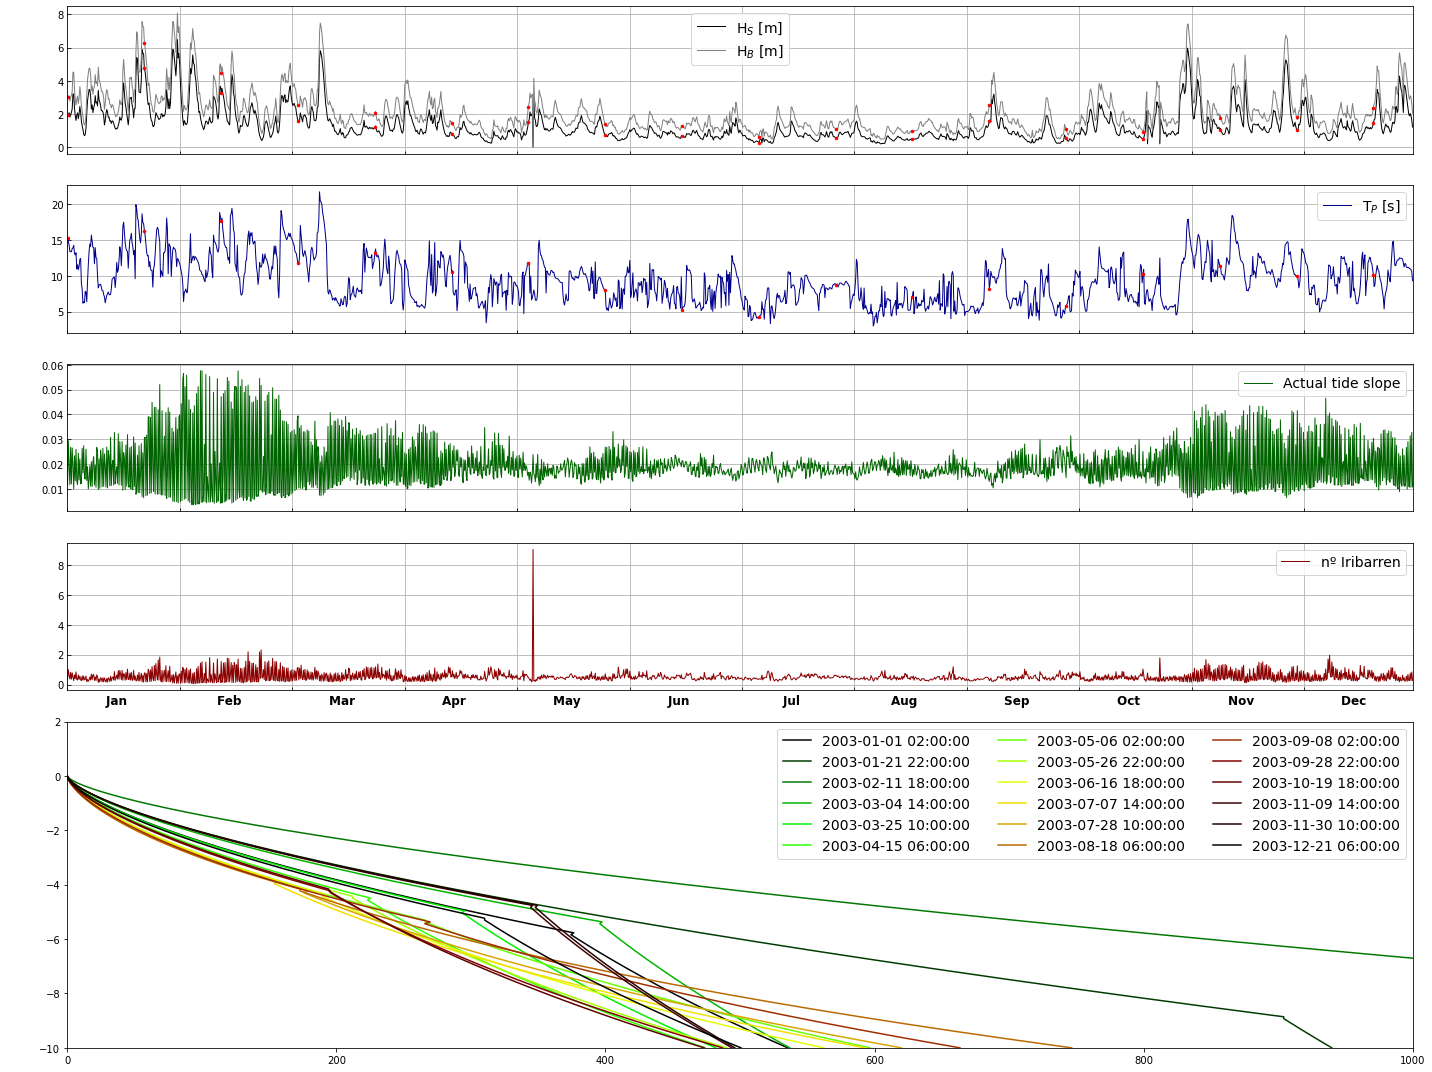

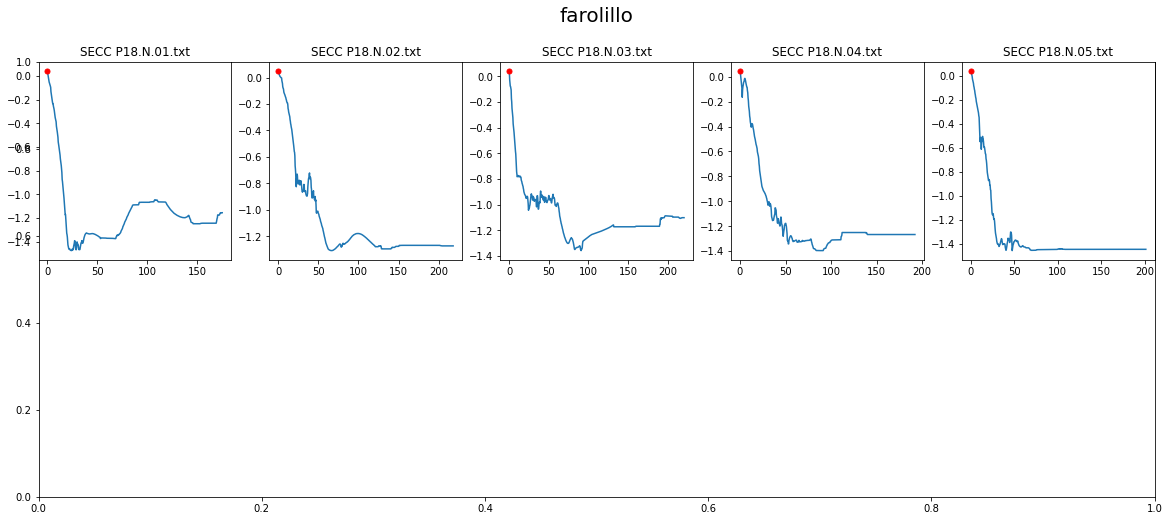

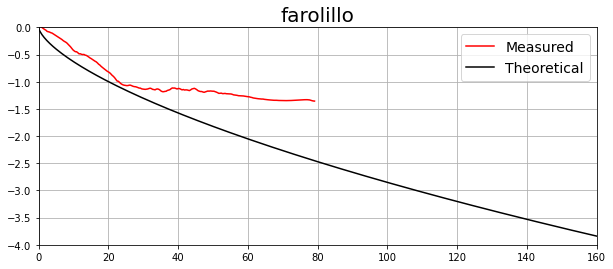

In [7]:
# Select the surfbreak
name = 'farolillo'
surfbreak = surfbreaks_historic.sel(beach=name).to_dataframe()
delta_angle = 6
wf = 0.030 
wf_calculated = wf_calc(1.2738, 0.6157)
print('The wf that will be used is: {}'.format(wf))
reconstructed_depth = 8
farolillo_slope = Slopes(reconstructed_data=surfbreak,
                         tides=tides,
                         delta_angle=delta_angle,
                         wf=wf,
                         name=name,
                         reconstructed_depth=reconstructed_depth)
farolillo_slope.perform_propagation()
farolillo_slope.moving_profile(year=2003)
farolillo_slope.data = index(farolillo_slope.data)
farolillo_slope.validate_profile(root=op.join(p_data, 'profiles'),
                                 omega=farolillo_slope.data.groupby('Month').mean().Omega.iloc[7], 
                                 diff_sl=0.5)
farolillo_slope.data['beach'] = name

The values of D50 and wf are, respectively: 0.3014229959588681, 0.031221225164497008
The wf that will be used is: 0.035

 Rolling mean and Ω calculated!! 


 Mean wave direction: 4.603694521931204 º 


 Mean wind direction: 9.78515820491844 º 


 Heights asomerament difference: Hb / Hs : 1.6398351228743209 


 Slopes main object constructed!! 


 Slopes main object finally constructed!! 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72019 entries, 1979-02-01 02:00:00 to 2020-02-29 20:00:00
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Hs          72019 non-null  float64
 1   Tp          72019 non-null  float64
 2   Dir         72019 non-null  float64
 3   Spr         72019 non-null  float64
 4   W           72019 non-null  float64
 5   DirW        72019 non-null  float64
 6   DDir        72019 non-null  float64
 7   DDirW       72019 non-null  float64
 8   ocean_tide  72019 non-null  float64
 9   Omega   

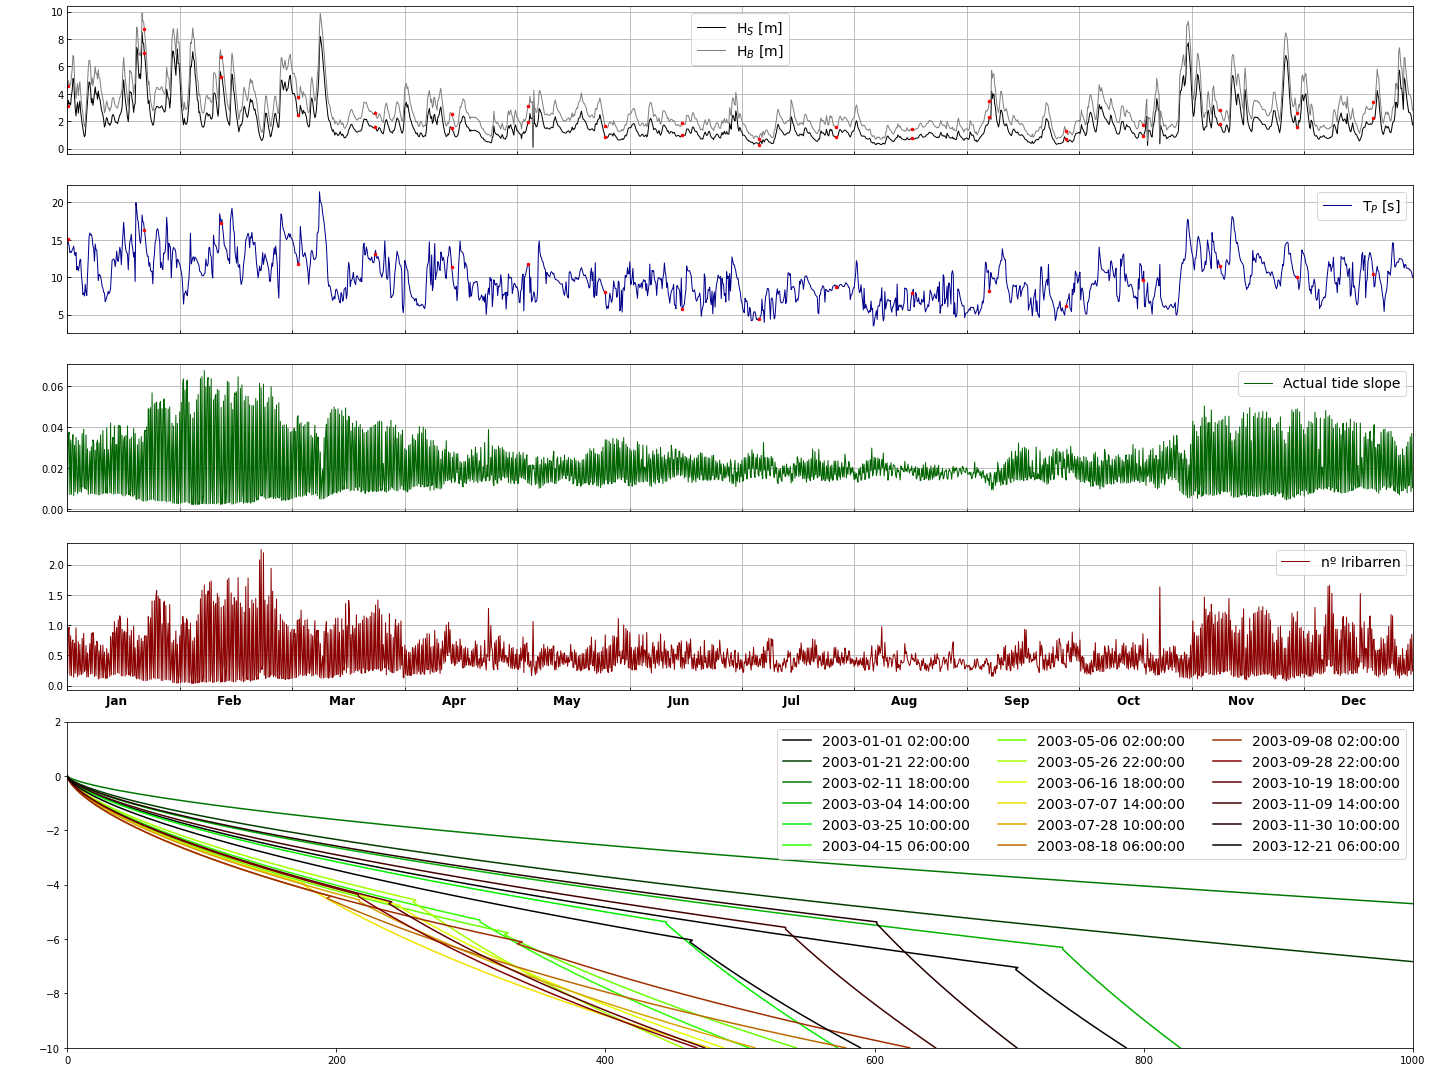

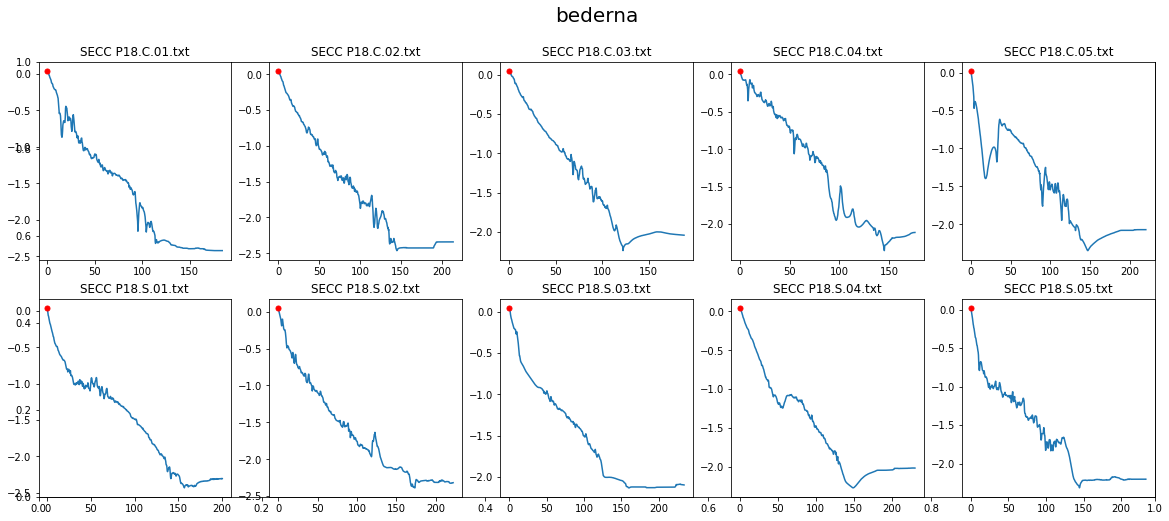

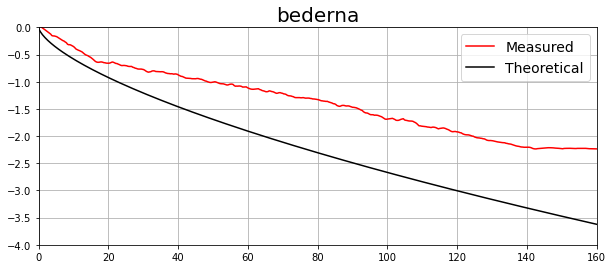

In [8]:
# Select the surfbreak
name = 'bederna'
surfbreak = surfbreaks_historic.sel(beach=name).to_dataframe()
delta_angle = 325
wf = 0.035 
wf_calculated = wf_calc(1.2897, 0.6585)
print('The wf that will be used is: {}'.format(wf))
reconstructed_depth = 8
bederna_slope = Slopes(reconstructed_data=surfbreak,
                       tides=tides,
                       delta_angle=delta_angle,
                       wf=wf,
                       name=name,
                       reconstructed_depth=reconstructed_depth)
bederna_slope.perform_propagation()
bederna_slope.moving_profile(year=2003)
bederna_slope.data = index(bederna_slope.data)
bederna_slope.validate_profile(root=op.join(p_data, 'profiles'),
                               omega=bederna_slope.data.groupby('Month').mean().Omega.iloc[7], 
                               diff_sl=1.5)
bederna_slope.data['beach'] = name

The values of D50 and wf are, respectively: 0.2264985199706587, 0.022799631428169796
The wf that will be used is: 0.028

 Rolling mean and Ω calculated!! 


 Mean wave direction: -73.41482525749146 º 


 Mean wind direction: -31.01464226066187 º 


 Heights asomerament difference: Hb / Hs : 1.1295916525429373 


 Slopes main object constructed!! 


 Slopes main object finally constructed!! 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72019 entries, 1979-02-01 02:00:00 to 2020-02-29 20:00:00
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Hs          72019 non-null  float64
 1   Tp          72019 non-null  float64
 2   Dir         72019 non-null  float64
 3   Spr         72019 non-null  float64
 4   W           72019 non-null  float64
 5   DirW        72019 non-null  float64
 6   DDir        72019 non-null  float64
 7   DDirW       72019 non-null  float64
 8   ocean_tide  72019 non-null  float64
 9   Omega

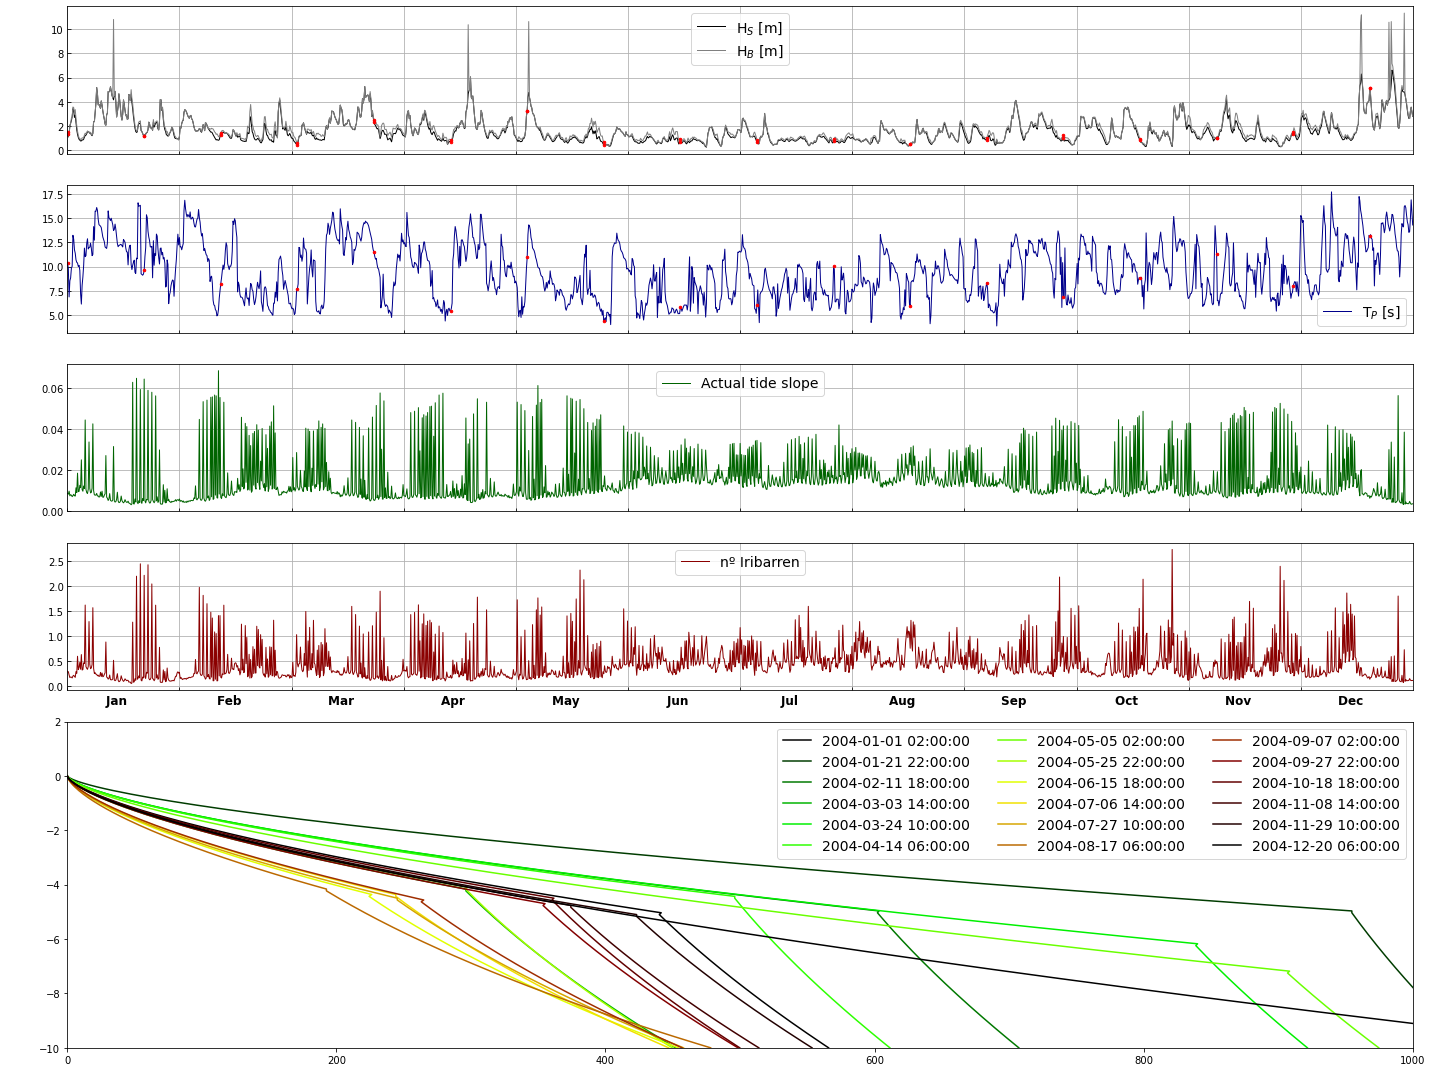

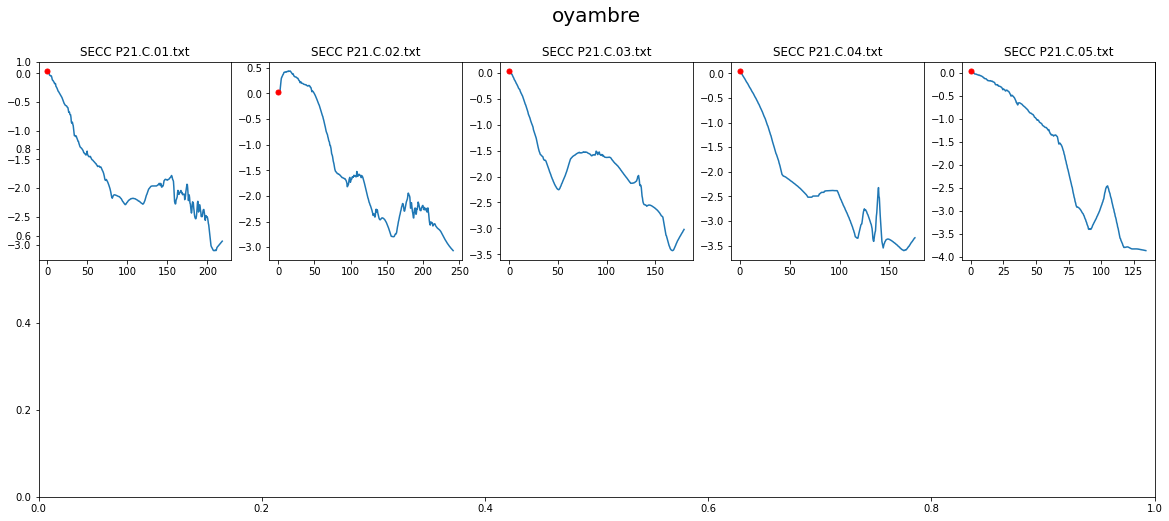

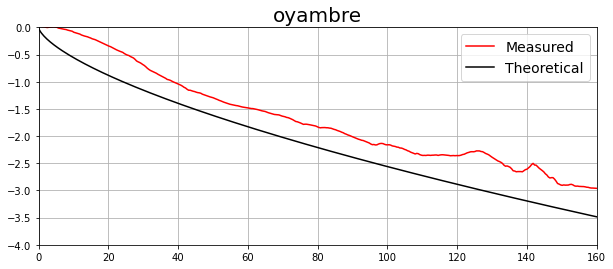

In [9]:
# Select the surfbreak
name = 'oyambre'
surfbreak = surfbreaks_historic.sel(beach=name).to_dataframe()
delta_angle = 70
wf = 0.028 
wf_calculated = wf_calc(1.2483, 0.5039)
print('The wf that will be used is: {}'.format(wf))
reconstructed_depth = 10
oyambre_slope = Slopes(reconstructed_data=surfbreak,
                       tides=tides,
                       delta_angle=delta_angle,
                       wf=wf,
                       name=name,
                       reconstructed_depth=reconstructed_depth)
oyambre_slope.perform_propagation()
oyambre_slope.moving_profile(year=2004)
oyambre_slope.data = index(oyambre_slope.data)
oyambre_slope.validate_profile(root=op.join(p_data, 'profiles'),
                               omega=oyambre_slope.data.groupby('Month').mean().Omega.iloc[7], 
                               diff_sl=0.5)
oyambre_slope.data['beach'] = name

The values of D50 and wf are, respectively: 0.4010634305424647, 0.042745489201382075
The wf that will be used is: 0.042745489201382075

 Rolling mean and Ω calculated!! 


 Mean wave direction: 25.465238302667395 º 


 Mean wind direction: 20.764539648217408 º 


 Heights asomerament difference: Hb / Hs : 1.437117075964364 


 Slopes main object constructed!! 


 Slopes main object finally constructed!! 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72019 entries, 1979-02-01 02:00:00 to 2020-02-29 20:00:00
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Hs          72019 non-null  float64
 1   Tp          72019 non-null  float64
 2   Dir         72019 non-null  float64
 3   Spr         72019 non-null  float64
 4   W           72019 non-null  float64
 5   DirW        72019 non-null  float64
 6   DDir        72019 non-null  float64
 7   DDirW       72019 non-null  float64
 8   ocean_tide  72019 non-null  floa

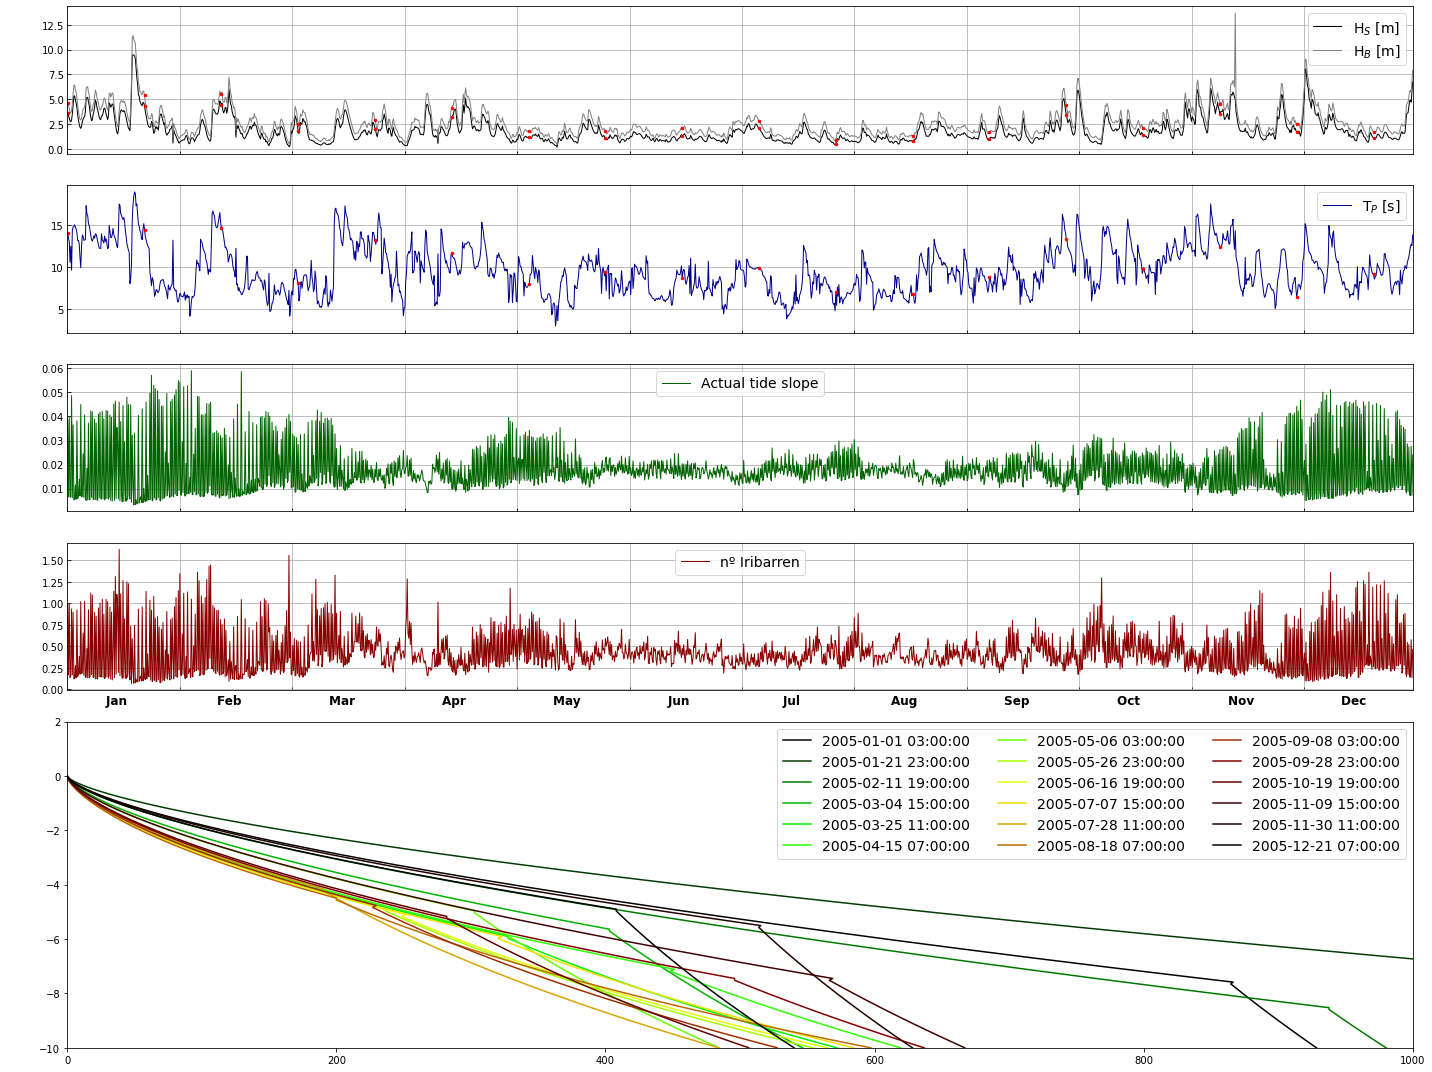

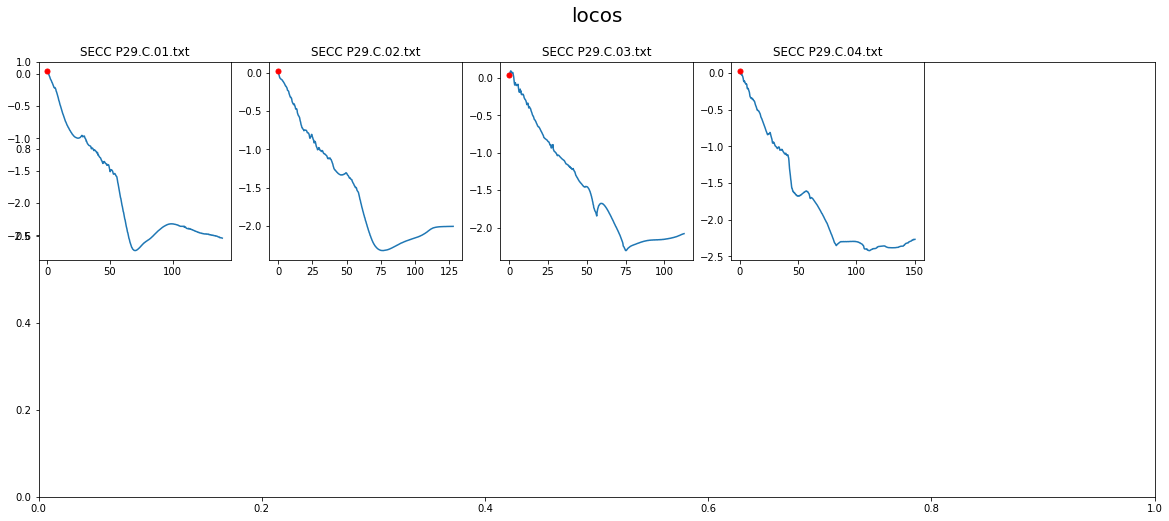

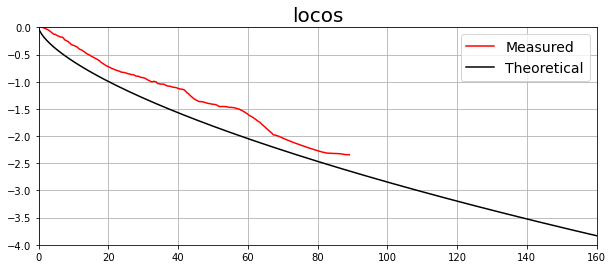

In [10]:
# Select the surfbreak
name = 'locos'
surfbreak = surfbreaks_historic.sel(beach=name).to_dataframe()
delta_angle = 295
wf = wf_calc(1.1104, 0.6681)
print('The wf that will be used is: {}'.format(wf))
reconstructed_depth = 5
locos_slope = Slopes(reconstructed_data=surfbreak,
                     tides=tides,
                     delta_angle=delta_angle,
                     wf=wf,
                     name=name,
                     reconstructed_depth=reconstructed_depth)
locos_slope.perform_propagation()
locos_slope.moving_profile(year=2005)
locos_slope.data = index(locos_slope.data)
locos_slope.validate_profile(root=op.join(p_data, 'profiles'),
                             omega=locos_slope.data.groupby('Month').mean().Omega.iloc[7],
                             diff_sl=0.5)
locos_slope.data['beach'] = name

The values of D50 and wf are, respectively: 0.4787036282026754, 0.051931314061067546
The wf that will be used is: 0.051931314061067546

 Rolling mean and Ω calculated!! 


 Mean wave direction: -8.975274244111828 º 


 Mean wind direction: 2.467233362883188 º 


 Heights asomerament difference: Hb / Hs : 1.6330347632186633 


 Slopes main object constructed!! 


 Slopes main object finally constructed!! 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72019 entries, 1979-02-01 02:00:00 to 2020-02-29 20:00:00
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Hs          72019 non-null  float64
 1   Tp          72019 non-null  float64
 2   Dir         72019 non-null  float64
 3   Spr         72019 non-null  float64
 4   W           72019 non-null  float64
 5   DirW        72019 non-null  float64
 6   DDir        72019 non-null  float64
 7   DDirW       72019 non-null  float64
 8   ocean_tide  72019 non-null  floa

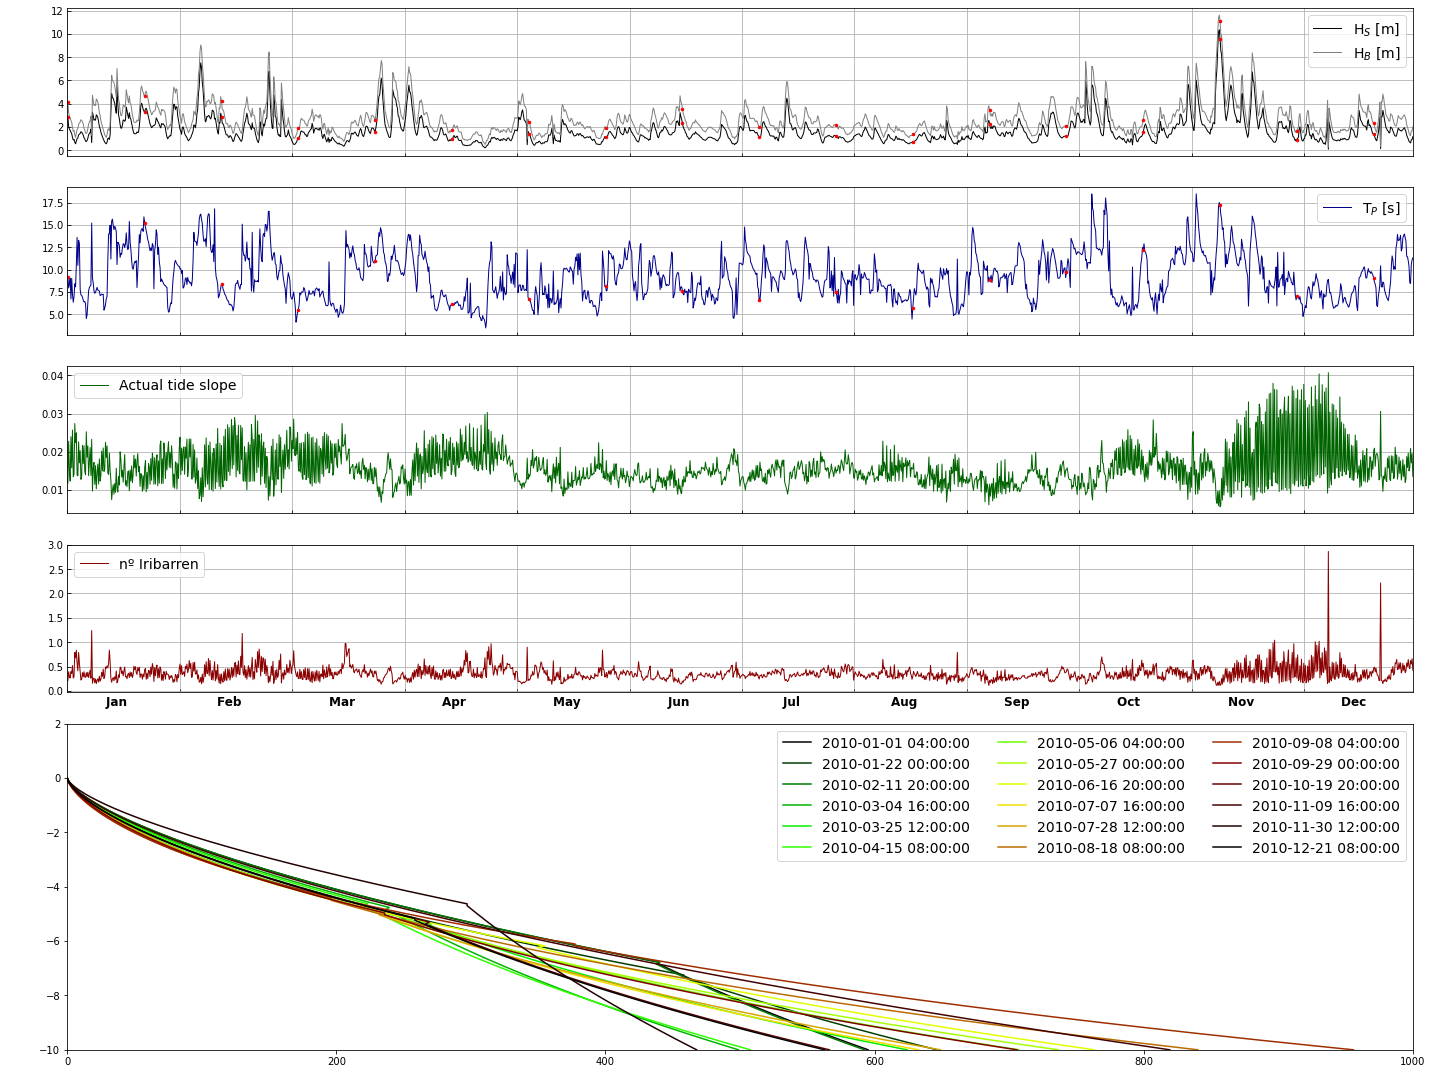

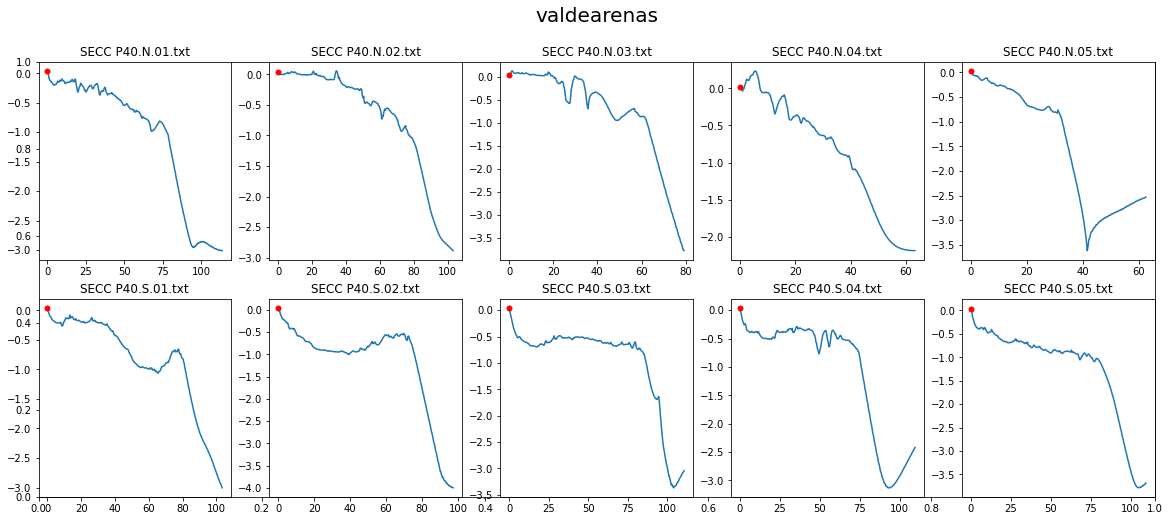

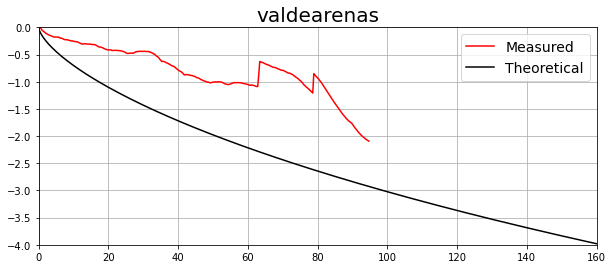

In [11]:
# Select the surfbreak
name = 'valdearenas'
surfbreak = surfbreaks_historic.sel(beach=name).to_dataframe()
delta_angle = 340
wf = wf_calc(0.9602, 0.6247)
print('The wf that will be used is: {}'.format(wf))
reconstructed_depth = 8
valdearenas_slope = Slopes(reconstructed_data=surfbreak,
                           tides=tides,
                           delta_angle=delta_angle,
                           wf=wf,
                           name=name,
                           reconstructed_depth=reconstructed_depth)
valdearenas_slope.perform_propagation()
valdearenas_slope.moving_profile(year=2010)
valdearenas_slope.data = index(valdearenas_slope.data)
valdearenas_slope.validate_profile(root=op.join(p_data, 'profiles'),
                                   omega=valdearenas_slope.data.groupby('Month').mean().Omega.iloc[7], 
                                   diff_sl=1.5)
valdearenas_slope.data['beach'] = name

The values of D50 and wf are, respectively: 0.4545577597672397, 0.04905732967163039
The wf that will be used is: 0.04905732967163039

 Rolling mean and Ω calculated!! 


 Mean wave direction: -27.102964299627416 º 


 Mean wind direction: -2.2949881203226643 º 


 Heights asomerament difference: Hb / Hs : 1.6833531174171443 


 Slopes main object constructed!! 


 Slopes main object finally constructed!! 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72019 entries, 1979-02-01 02:00:00 to 2020-02-29 20:00:00
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Hs          72019 non-null  float64
 1   Tp          72019 non-null  float64
 2   Dir         72019 non-null  float64
 3   Spr         72019 non-null  float64
 4   W           72019 non-null  float64
 5   DirW        72019 non-null  float64
 6   DDir        72019 non-null  float64
 7   DDirW       72019 non-null  float64
 8   ocean_tide  72019 non-null  flo

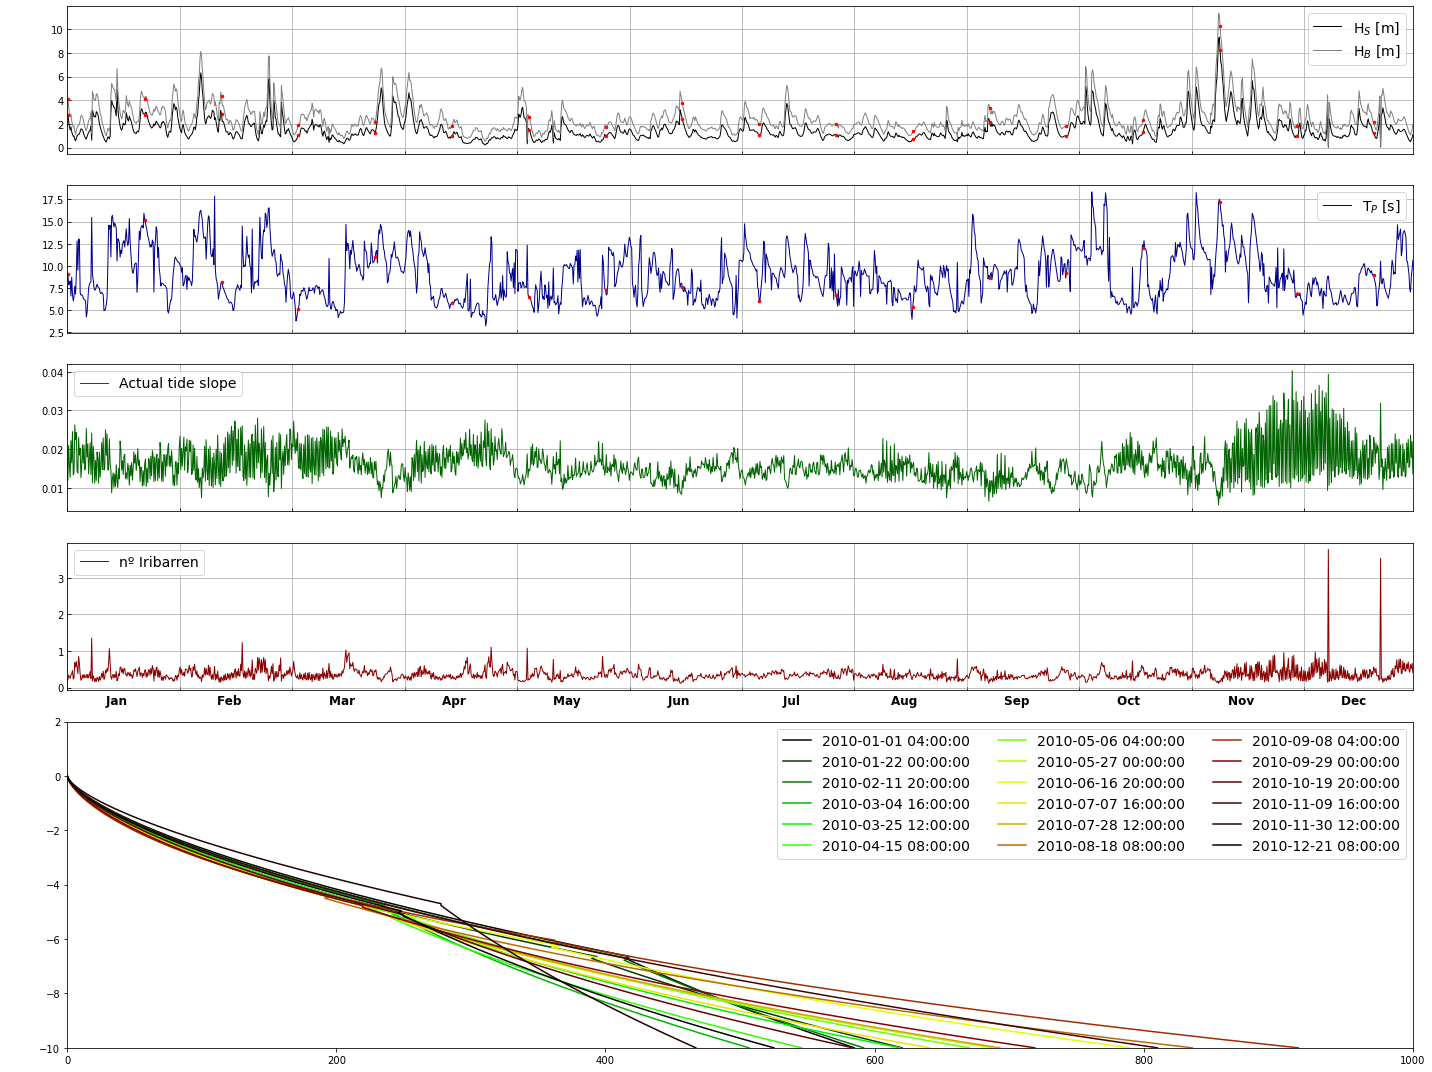

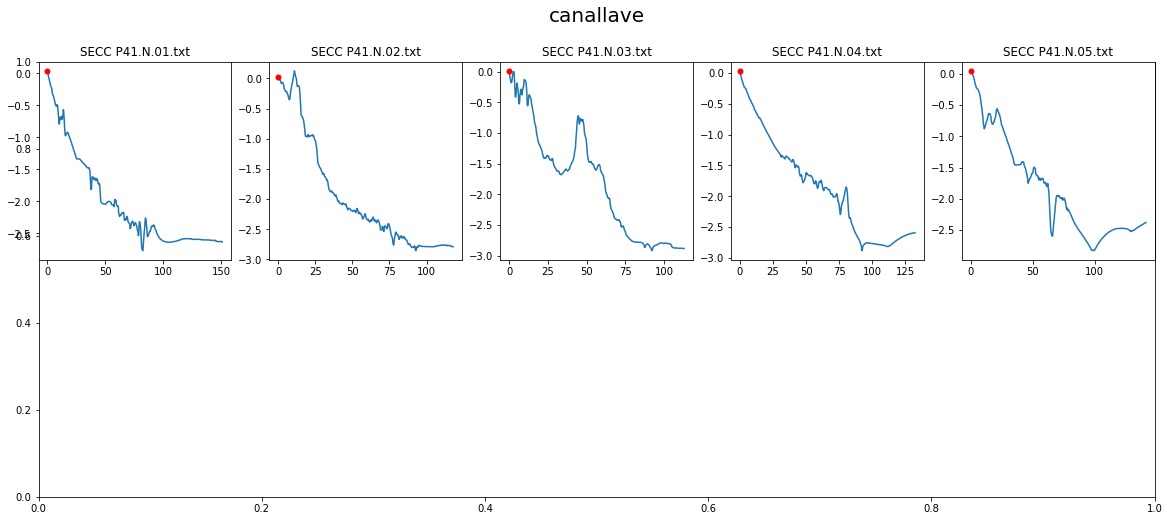

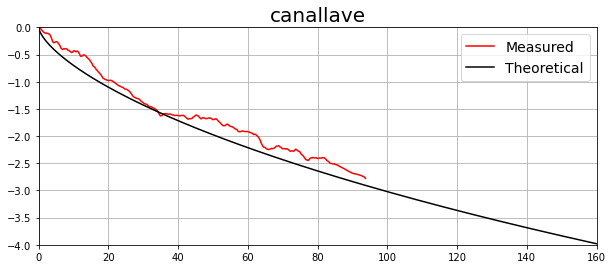

In [12]:
# Select the surfbreak
name = 'canallave'
surfbreak = surfbreaks_historic.sel(beach=name).to_dataframe()
delta_angle = 350
wf = wf_calc(0.9852, 0.6154)
print('The wf that will be used is: {}'.format(wf))
reconstructed_depth = 10
canallave_slope = Slopes(reconstructed_data=surfbreak,
                         tides=tides,
                         delta_angle=delta_angle,
                         wf=wf,
                         name=name,
                         reconstructed_depth=reconstructed_depth)
canallave_slope.perform_propagation()
canallave_slope.moving_profile(year=2010)
canallave_slope.data = index(canallave_slope.data)
canallave_slope.validate_profile(root=op.join(p_data, 'profiles'),
                                 omega=canallave_slope.data.groupby('Month').mean().Omega.iloc[7], 
                                 diff_sl=1.5)
canallave_slope.data['beach'] = name

The values of D50 and wf are, respectively: 0.3581236801815413, 0.03773916297995551
The wf that will be used is: 0.047

 Rolling mean and Ω calculated!! 


 Mean wave direction: -25.106096208720885 º 


 Mean wind direction: -2.2949881203226643 º 


 Heights asomerament difference: Hb / Hs : 1.6907088860620965 


 Slopes main object constructed!! 


 Slopes main object finally constructed!! 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72019 entries, 1979-02-01 02:00:00 to 2020-02-29 20:00:00
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Hs          72019 non-null  float64
 1   Tp          72019 non-null  float64
 2   Dir         72019 non-null  float64
 3   Spr         72019 non-null  float64
 4   W           72019 non-null  float64
 5   DirW        72019 non-null  float64
 6   DDir        72019 non-null  float64
 7   DDirW       72019 non-null  float64
 8   ocean_tide  72019 non-null  float64
 9   Omeg

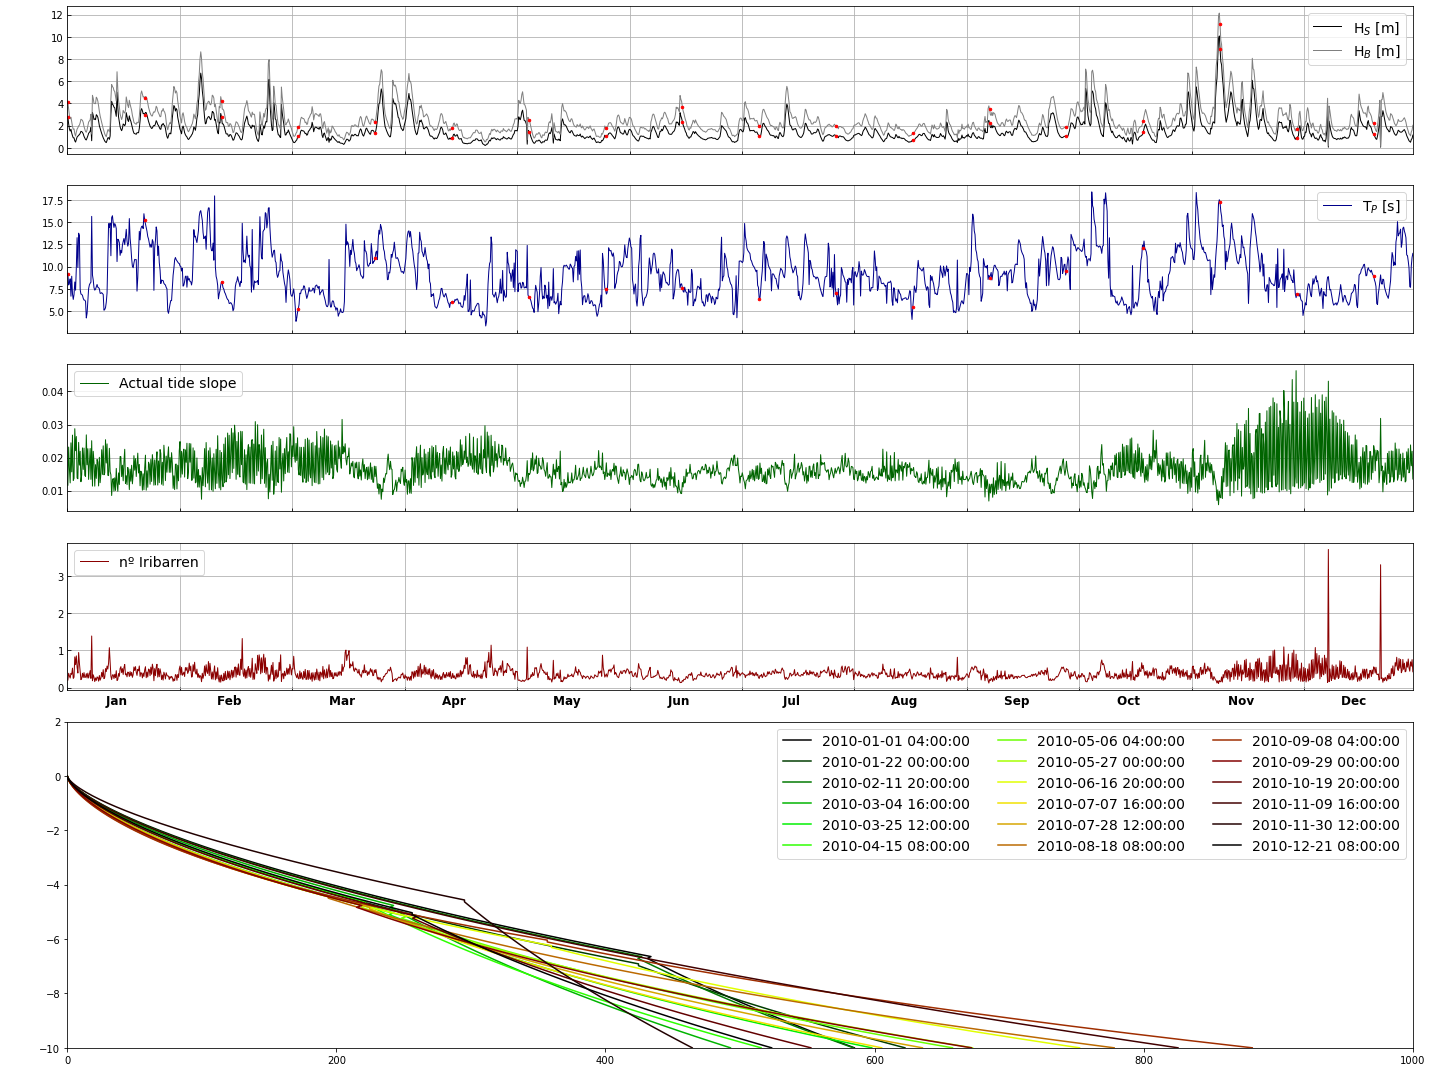

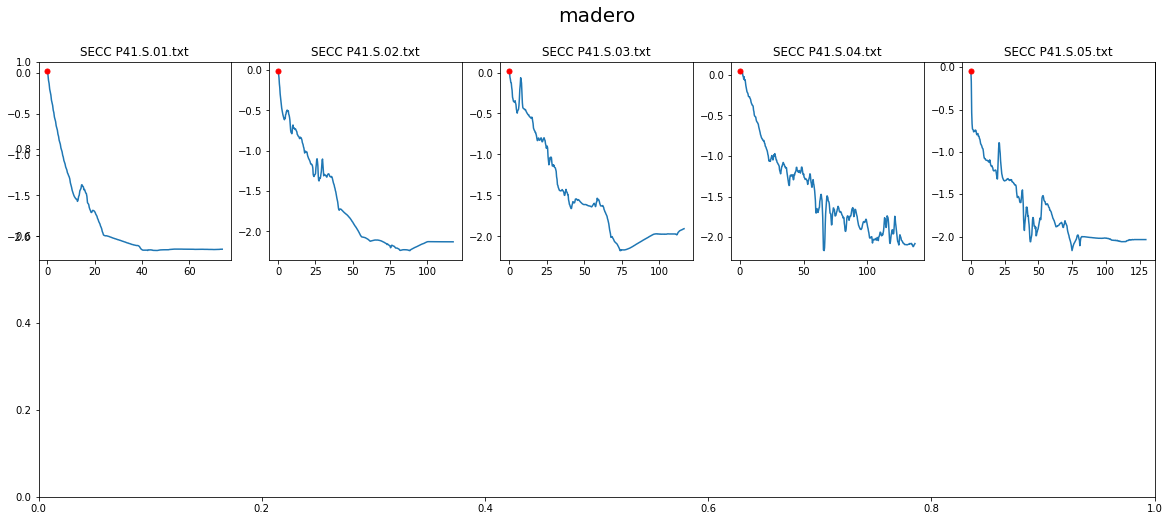

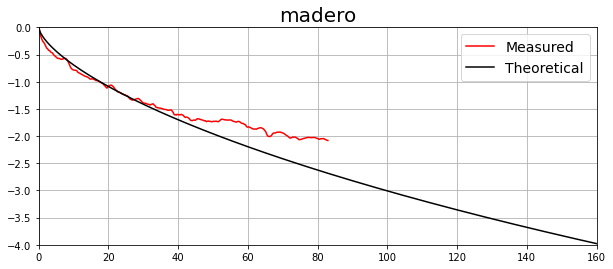

In [13]:
# Select the surfbreak
name = 'madero'
surfbreak = surfbreaks_historic.sel(beach=name).to_dataframe()
delta_angle = 350
wf = 0.047 
wf_calculated = wf_calc(1.1839, 0.6660)
print('The wf that will be used is: {}'.format(wf))
reconstructed_depth = 10
madero_slope = Slopes(reconstructed_data=surfbreak,
                      tides=tides,
                      delta_angle=delta_angle,
                      wf=wf,
                      name=name,
                      reconstructed_depth=reconstructed_depth)
madero_slope.perform_propagation()
madero_slope.moving_profile(year=2010)
madero_slope.data = index(madero_slope.data)
madero_slope.validate_profile(root=op.join(p_data, 'profiles'),
                              omega=madero_slope.data.groupby('Month').mean().Omega.iloc[7],  
                              diff_sl=0.8)
madero_slope.data['beach'] = name

The values of D50 and wf are, respectively: 0.36423679473213266, 0.038448386404837304
The wf that will be used is: 0.022

 Rolling mean and Ω calculated!! 


 Mean wave direction: -76.70821460688457 º 


 Mean wind direction: -31.46026913129706 º 


 Heights asomerament difference: Hb / Hs : 1.120889300470879 


 Slopes main object constructed!! 


 Slopes main object finally constructed!! 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72019 entries, 1979-02-01 02:00:00 to 2020-02-29 20:00:00
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Hs          72019 non-null  float64
 1   Tp          72019 non-null  float64
 2   Dir         72019 non-null  float64
 3   Spr         72019 non-null  float64
 4   W           72019 non-null  float64
 5   DirW        72019 non-null  float64
 6   DDir        72019 non-null  float64
 7   DDirW       72019 non-null  float64
 8   ocean_tide  72019 non-null  float64
 9   Omega

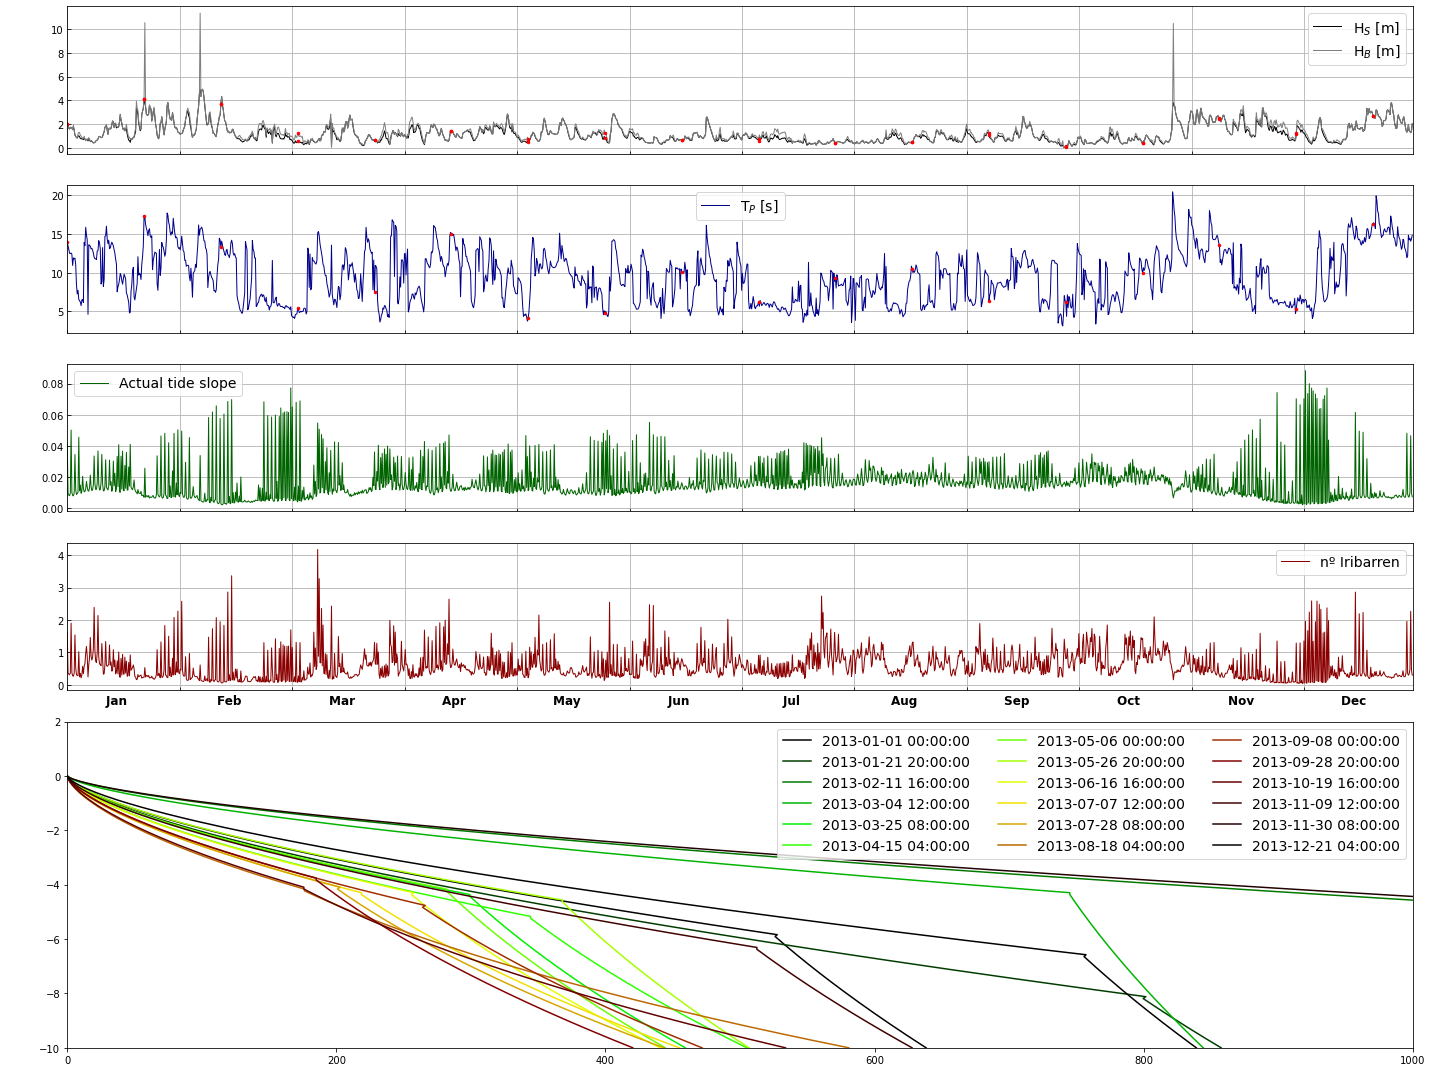

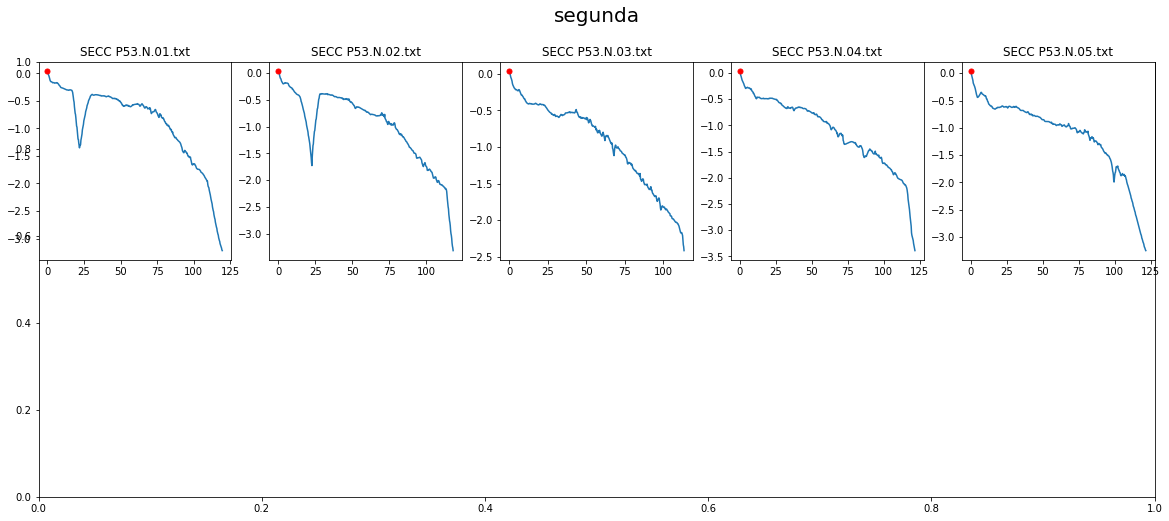

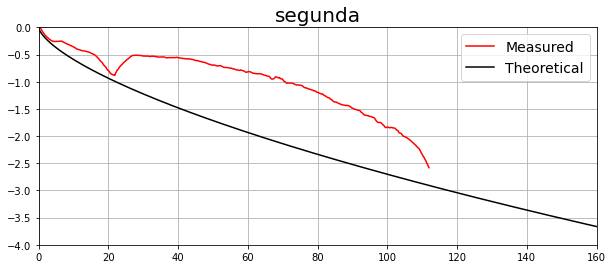

In [14]:
# Select the surfbreak
name = 'segunda'
surfbreak = surfbreaks_historic.sel(beach=name).to_dataframe()
delta_angle = 75
wf = 0.022 
wf_calulated = wf_calc(1.0988, 0.5929)
print('The wf that will be used is: {}'.format(wf))
reconstructed_depth = 10
segunda_slope = Slopes(reconstructed_data=surfbreak,
                       tides=tides,
                       delta_angle=delta_angle,
                       wf=wf,
                       name=name,
                       reconstructed_depth=reconstructed_depth)
segunda_slope.perform_propagation()
segunda_slope.moving_profile(year=2013)
segunda_slope.data = index(segunda_slope.data)
segunda_slope.validate_profile(root=op.join(p_data, 'profiles'),
                               omega=segunda_slope.data.groupby('Month').mean().Omega.iloc[7], 
                               diff_sl=1.0)
segunda_slope.data['beach'] = name

The values of D50 and wf are, respectively: 0.3558959439550598, 0.03748100810819603
The wf that will be used is: 0.024

 Rolling mean and Ω calculated!! 


 Mean wave direction: -33.93958535504187 º 


 Mean wind direction: -31.01464226066187 º 


 Heights asomerament difference: Hb / Hs : 1.8970812974240645 


 Slopes main object constructed!! 


 Slopes main object finally constructed!! 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72019 entries, 1979-02-01 02:00:00 to 2020-02-29 20:00:00
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Hs          72019 non-null  float64
 1   Tp          72019 non-null  float64
 2   Dir         72019 non-null  float64
 3   Spr         72019 non-null  float64
 4   W           72019 non-null  float64
 5   DirW        72019 non-null  float64
 6   DDir        72019 non-null  float64
 7   DDirW       72019 non-null  float64
 8   ocean_tide  72019 non-null  float64
 9   Omega 

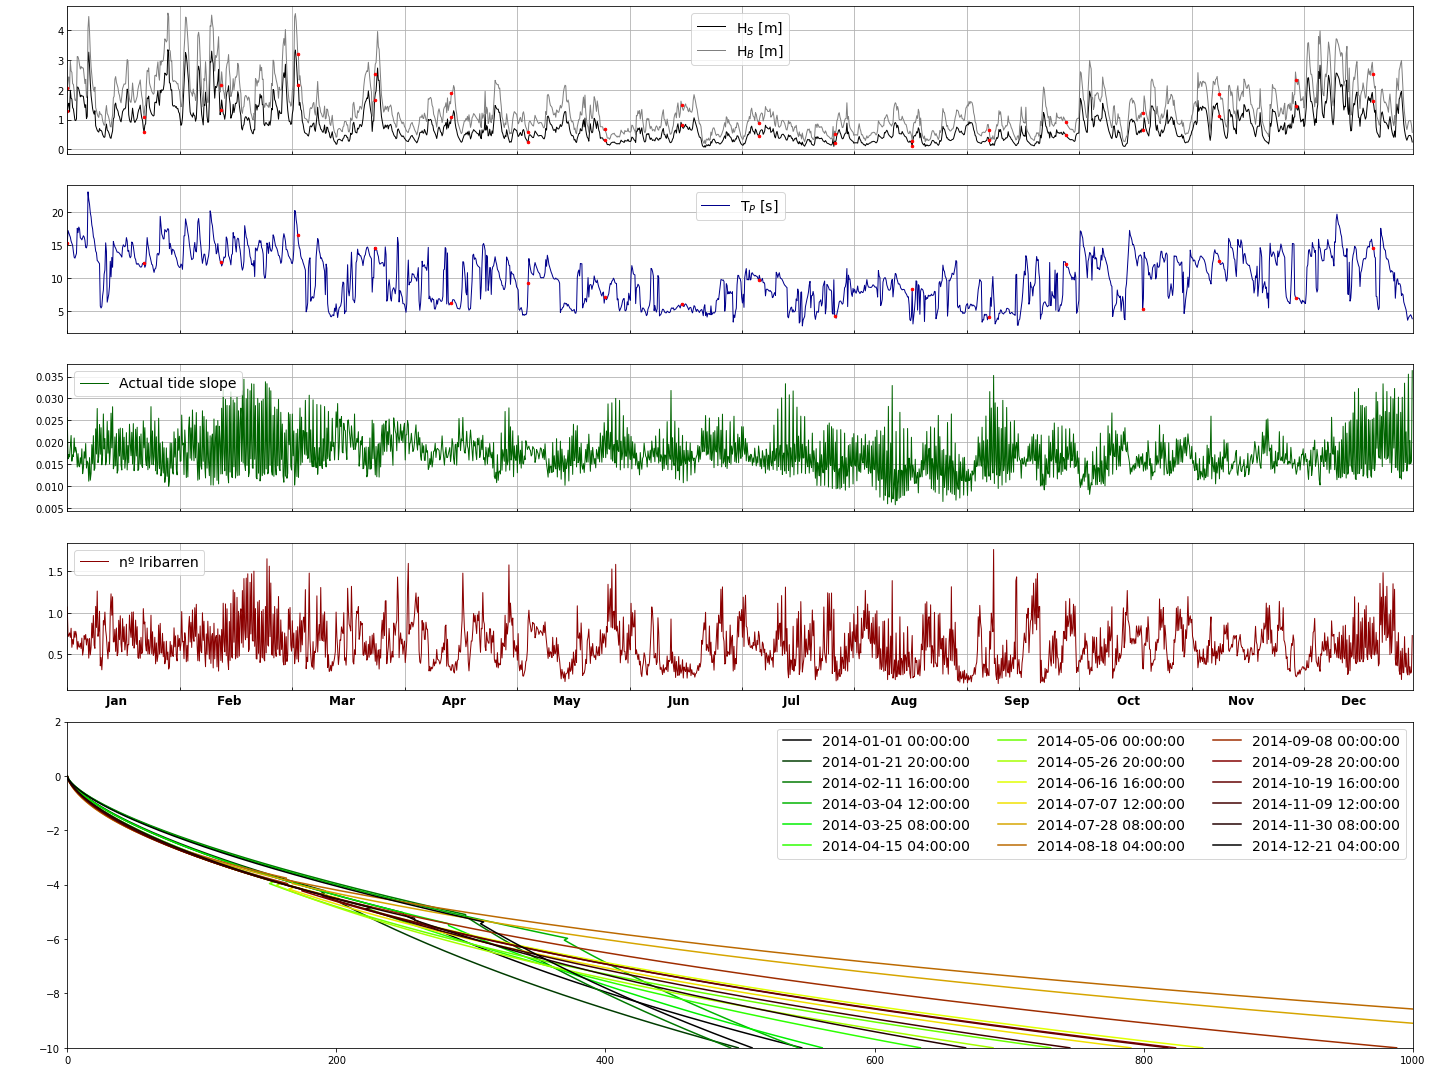

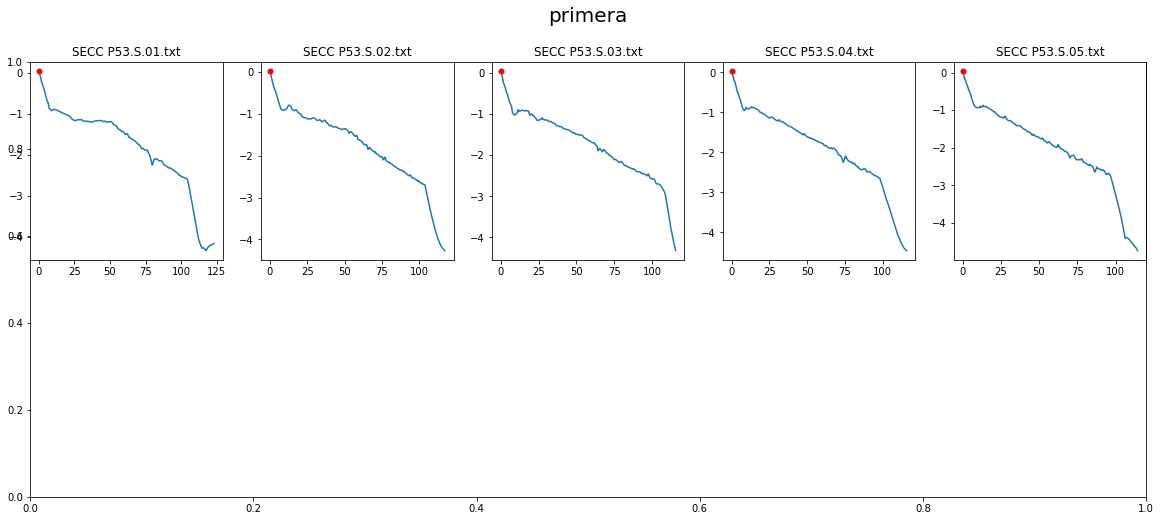

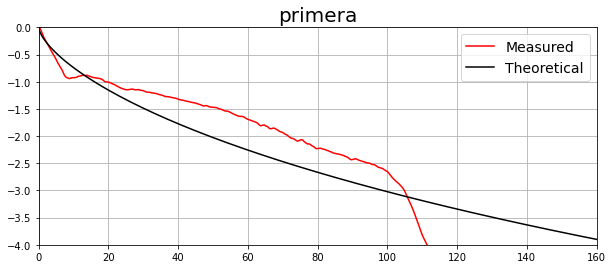

In [15]:
# Select the surfbreak
name = 'primera'
surfbreak = surfbreaks_historic.sel(beach=name).to_dataframe()
delta_angle = 70
wf = 0.024 
wf_calculated = wf_calc(1.1364, 0.6160)
print('The wf that will be used is: {}'.format(wf))
reconstructed_depth = 8
primera_slope = Slopes(reconstructed_data=surfbreak,
                       tides=tides,
                       delta_angle=delta_angle,
                       wf=wf,
                       name=name,
                       reconstructed_depth=reconstructed_depth)
primera_slope.perform_propagation()
primera_slope.moving_profile(year=2014)
primera_slope.data = index(primera_slope.data)
primera_slope.validate_profile(root=op.join(p_data, 'profiles'),
                               omega=primera_slope.data.groupby('Month').mean().Omega.iloc[7], 
                               diff_sl=1.5)
primera_slope.data['beach'] = name

The values of D50 and wf are, respectively: 0.3041813281790857, 0.03153564572726523
The wf that will be used is: 0.032

 Rolling mean and Ω calculated!! 


 Mean wave direction: -12.683316823428534 º 


 Mean wind direction: -4.301971825011723 º 


 Heights asomerament difference: Hb / Hs : 1.8018422576128574 


 Slopes main object constructed!! 


 Slopes main object finally constructed!! 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72019 entries, 1979-02-01 02:00:00 to 2020-02-29 20:00:00
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Hs          72019 non-null  float64
 1   Tp          72019 non-null  float64
 2   Dir         72019 non-null  float64
 3   Spr         72019 non-null  float64
 4   W           72019 non-null  float64
 5   DirW        72019 non-null  float64
 6   DDir        72019 non-null  float64
 7   DDirW       72019 non-null  float64
 8   ocean_tide  72019 non-null  float64
 9   Omega

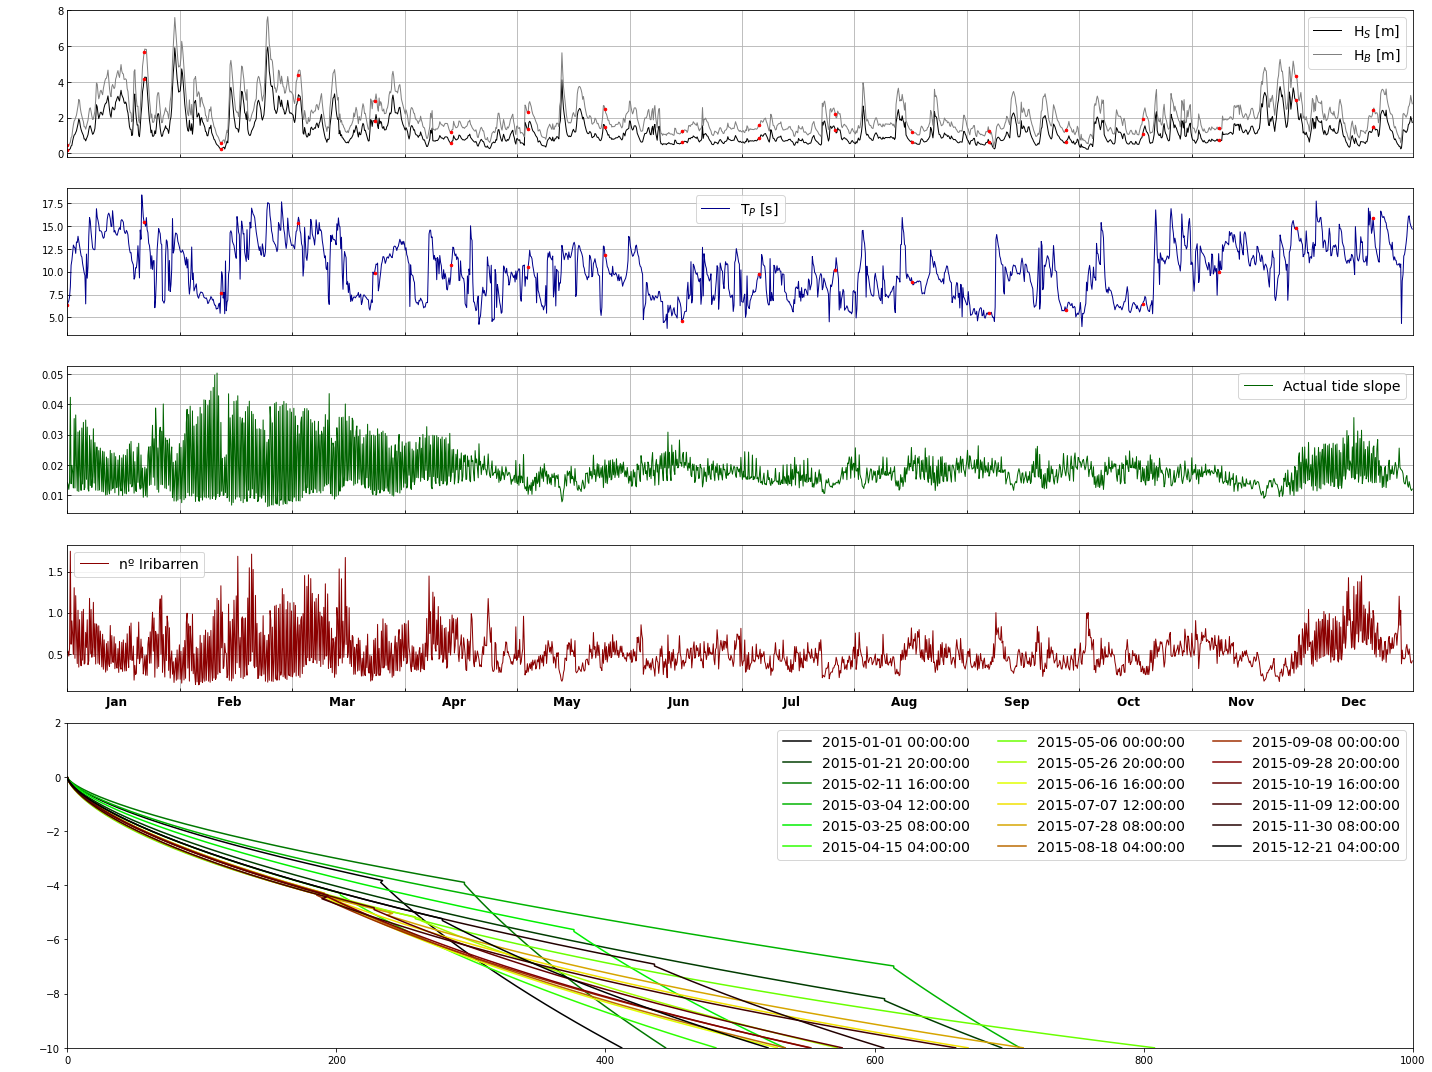

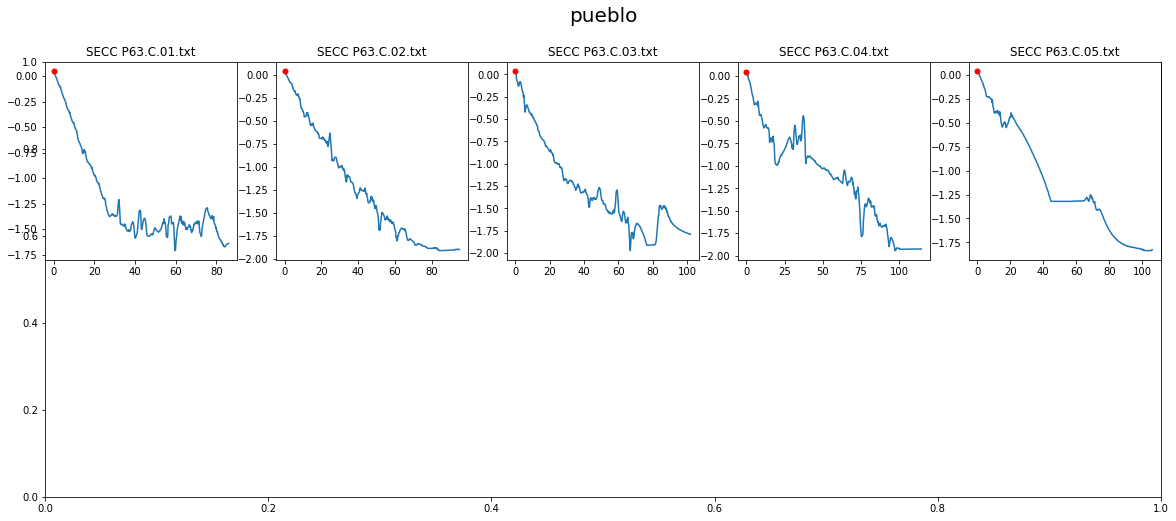

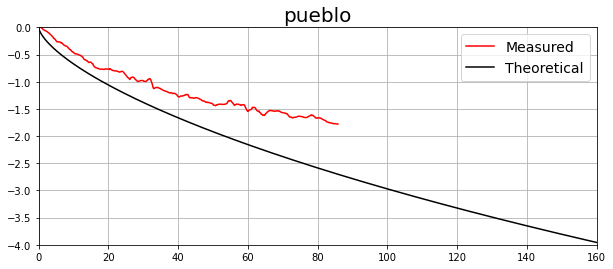

In [16]:
# Select the surfbreak
name = 'pueblo'
surfbreak = surfbreaks_historic.sel(beach=name).to_dataframe()
delta_angle = 355
wf = 0.032 
wf_calculated = wf_calc(1.2887, 0.6627)
print('The wf that will be used is: {}'.format(wf))
reconstructed_depth = 8
pueblo_slope = Slopes(reconstructed_data=surfbreak,
                      tides=tides,
                      delta_angle=delta_angle,
                      wf=wf,
                      name=name,
                      reconstructed_depth=reconstructed_depth)
pueblo_slope.perform_propagation()
pueblo_slope.moving_profile(year=2015)
pueblo_slope.data = index(pueblo_slope.data)
pueblo_slope.validate_profile(root=op.join(p_data, 'profiles'),
                              omega=pueblo_slope.data.groupby('Month').mean().Omega.iloc[7], 
                              diff_sl=1.6)
pueblo_slope.data['beach'] = name

The values of D50 and wf are, respectively: 0.44761270134600556, 0.048233476184614384
The wf that will be used is: 0.036

 Rolling mean and Ω calculated!! 


 Mean wave direction: 5.63806551783085 º 


 Mean wind direction: 2.467233362883188 º 


 Heights asomerament difference: Hb / Hs : 1.6539946516381308 


 Slopes main object constructed!! 


 Slopes main object finally constructed!! 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72019 entries, 1979-02-01 02:00:00 to 2020-02-29 20:00:00
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Hs          72019 non-null  float64
 1   Tp          72019 non-null  float64
 2   Dir         72019 non-null  float64
 3   Spr         72019 non-null  float64
 4   W           72019 non-null  float64
 5   DirW        72019 non-null  float64
 6   DDir        72019 non-null  float64
 7   DDirW       72019 non-null  float64
 8   ocean_tide  72019 non-null  float64
 9   Omega  

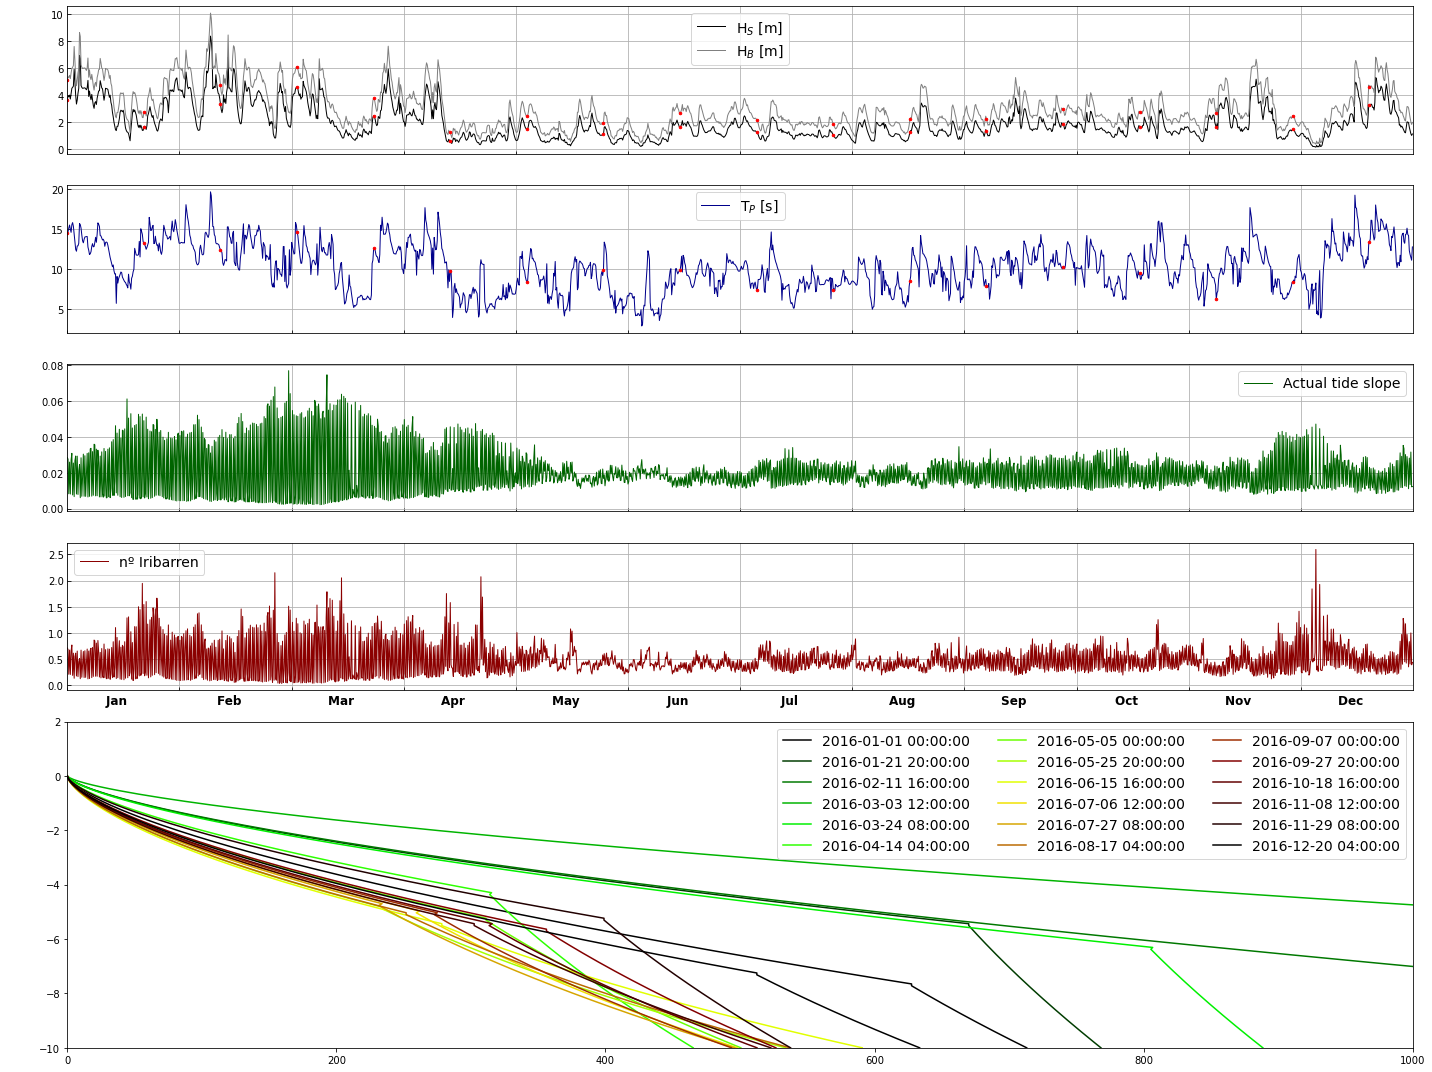

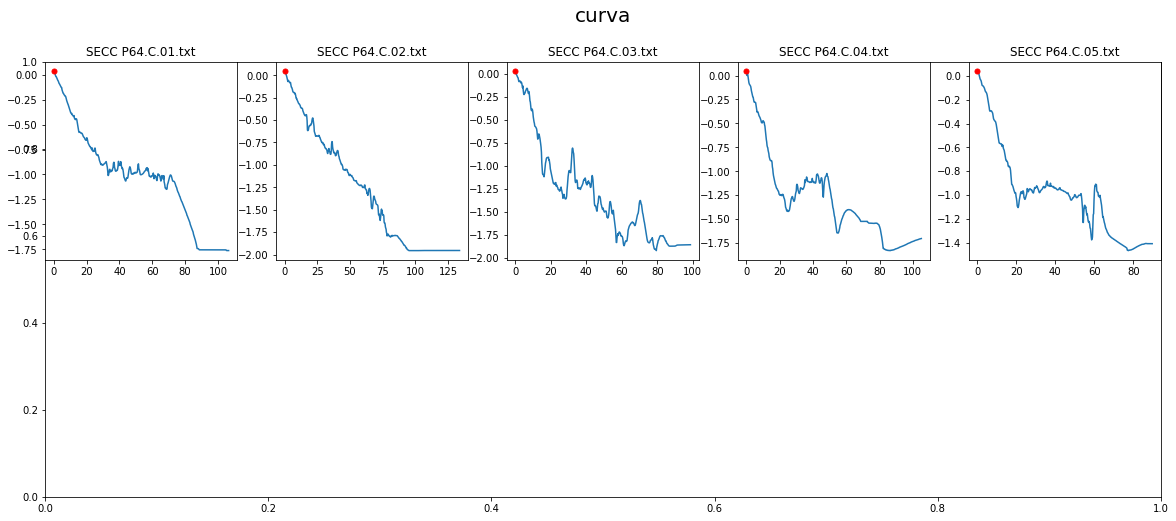

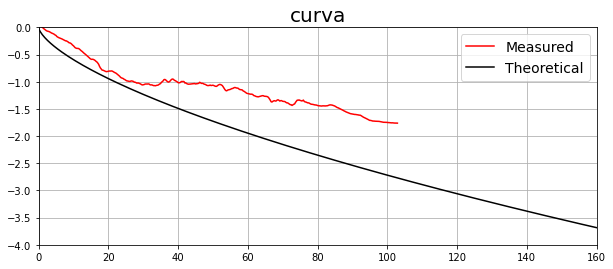

In [17]:
# Select the surfbreak
name = 'curva'
surfbreak = surfbreaks_historic.sel(beach=name).to_dataframe()
delta_angle = 340
wf = 0.036 
wf_calculated = wf_calc(0.9663, 0.5801)
print('The wf that will be used is: {}'.format(wf))
reconstructed_depth = 8
curva_slope = Slopes(reconstructed_data=surfbreak,
                     tides=tides,
                     delta_angle=delta_angle,
                     wf=wf,
                     name=name,
                     reconstructed_depth=reconstructed_depth)
curva_slope.perform_propagation()
curva_slope.moving_profile(year=2016)
curva_slope.data = index(curva_slope.data)
curva_slope.validate_profile(root=op.join(p_data, 'profiles'),
                             omega=curva_slope.data.groupby('Month').mean().Omega.iloc[7], 
                             diff_sl=1.5)
curva_slope.data['beach'] = name

The values of D50 and wf are, respectively: 0.2513298194182252, 0.02556373707462448
The wf that will be used is: 0.034

 Rolling mean and Ω calculated!! 


 Mean wave direction: -15.81709037026866 º 


 Mean wind direction: -9.365157724579399 º 


 Heights asomerament difference: Hb / Hs : 1.4433399236199291 


 Slopes main object constructed!! 


 Slopes main object finally constructed!! 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72019 entries, 1979-02-01 02:00:00 to 2020-02-29 20:00:00
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Hs          72019 non-null  float64
 1   Tp          72019 non-null  float64
 2   Dir         72019 non-null  float64
 3   Spr         72019 non-null  float64
 4   W           72019 non-null  float64
 5   DirW        72019 non-null  float64
 6   DDir        72019 non-null  float64
 7   DDirW       72019 non-null  float64
 8   ocean_tide  72019 non-null  float64
 9   Omega 

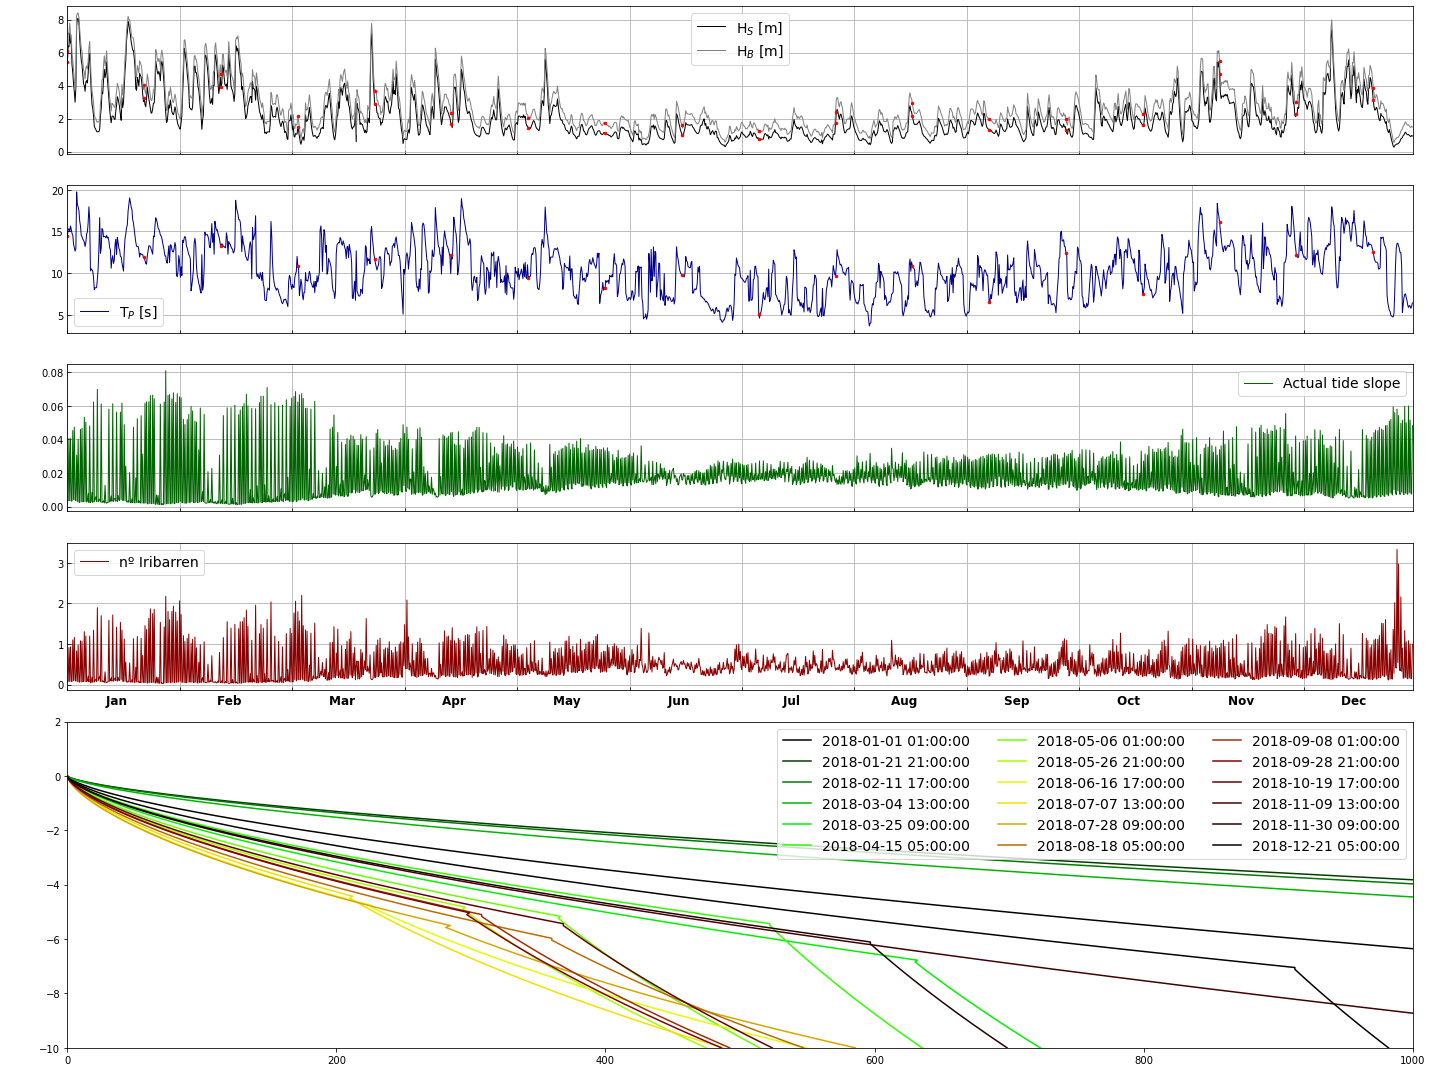

In [18]:
# Select the surfbreak
name = 'brusco'
surfbreak = surfbreaks_historic.sel(beach=name).to_dataframe()
delta_angle = 10
wf = 0.034 
wf_calculated = wf_calc(1.2148, 0.5176)
print('The wf that will be used is: {}'.format(wf))
reconstructed_depth = 4
brusco_slope = Slopes(reconstructed_data=surfbreak,
                      tides=tides,
                      delta_angle=delta_angle,
                      wf=wf,
                      name=name,
                      reconstructed_depth=reconstructed_depth)
brusco_slope.perform_propagation()
brusco_slope.moving_profile(year=2018)
brusco_slope.data = index(brusco_slope.data)
brusco_slope.data['beach'] = name

The wf that will be used is: 0.025

 Rolling mean and Ω calculated!! 


 Mean wave direction: -34.66056423091623 º 


 Mean wind direction: -31.01464226066187 º 


 Heights asomerament difference: Hb / Hs : 1.8196771203517437 


 Slopes main object constructed!! 


 Slopes main object finally constructed!! 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72019 entries, 1979-02-01 02:00:00 to 2020-02-29 20:00:00
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Hs          72019 non-null  float64
 1   Tp          72019 non-null  float64
 2   Dir         72019 non-null  float64
 3   Spr         72019 non-null  float64
 4   W           72019 non-null  float64
 5   DirW        72019 non-null  float64
 6   DDir        72019 non-null  float64
 7   DDirW       72019 non-null  float64
 8   ocean_tide  72019 non-null  float64
 9   Omega       72019 non-null  float64
 10  H_break     72019 non-null  float64
 11  DDir_R  

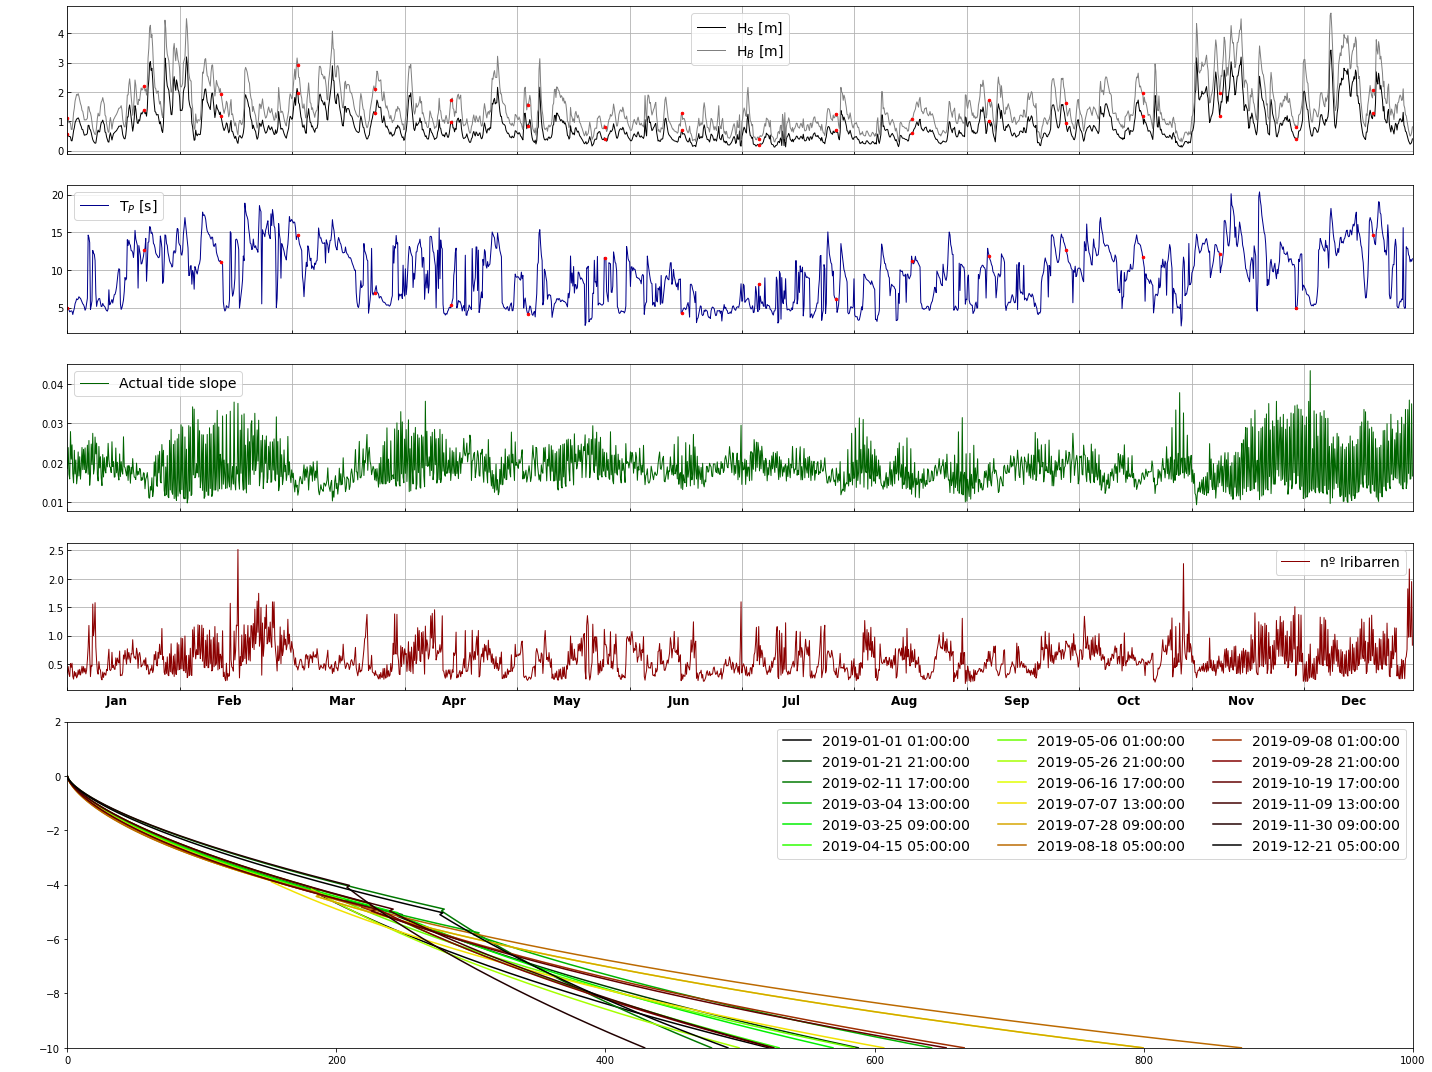

In [19]:
# Select the surfbreak
name = 'laredo'
surfbreak = surfbreaks_historic.sel(beach=name).to_dataframe()
delta_angle = 70
wf = 0.025
print('The wf that will be used is: {}'.format(wf))
reconstructed_depth = 8
laredo_slope = Slopes(reconstructed_data=surfbreak,
                      tides=tides,
                      delta_angle=delta_angle,
                      wf=wf,
                      name=name,
                      reconstructed_depth=reconstructed_depth)
laredo_slope.perform_propagation()
laredo_slope.moving_profile(year=2019)
laredo_slope.data = index(laredo_slope.data)
laredo_slope.data['beach'] = name

The wf that will be used is: 0.015

 Rolling mean and Ω calculated!! 


 Mean wave direction: -116.51880098209135 º 


 Mean wind direction: 9.269694287392666 º 


 Heights asomerament difference: Hb / Hs : 1.0 


 Slopes main object constructed!! 


 Slopes main object finally constructed!! 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72019 entries, 1979-02-01 02:00:00 to 2020-02-29 20:00:00
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Hs          72019 non-null  float64
 1   Tp          72019 non-null  float64
 2   Dir         72019 non-null  float64
 3   Spr         72019 non-null  float64
 4   W           72019 non-null  float64
 5   DirW        72019 non-null  float64
 6   DDir        72019 non-null  float64
 7   DDirW       72019 non-null  float64
 8   ocean_tide  72019 non-null  float64
 9   Omega       72019 non-null  float64
 10  H_break     72019 non-null  float64
 11  DDir_R      72019 non-n

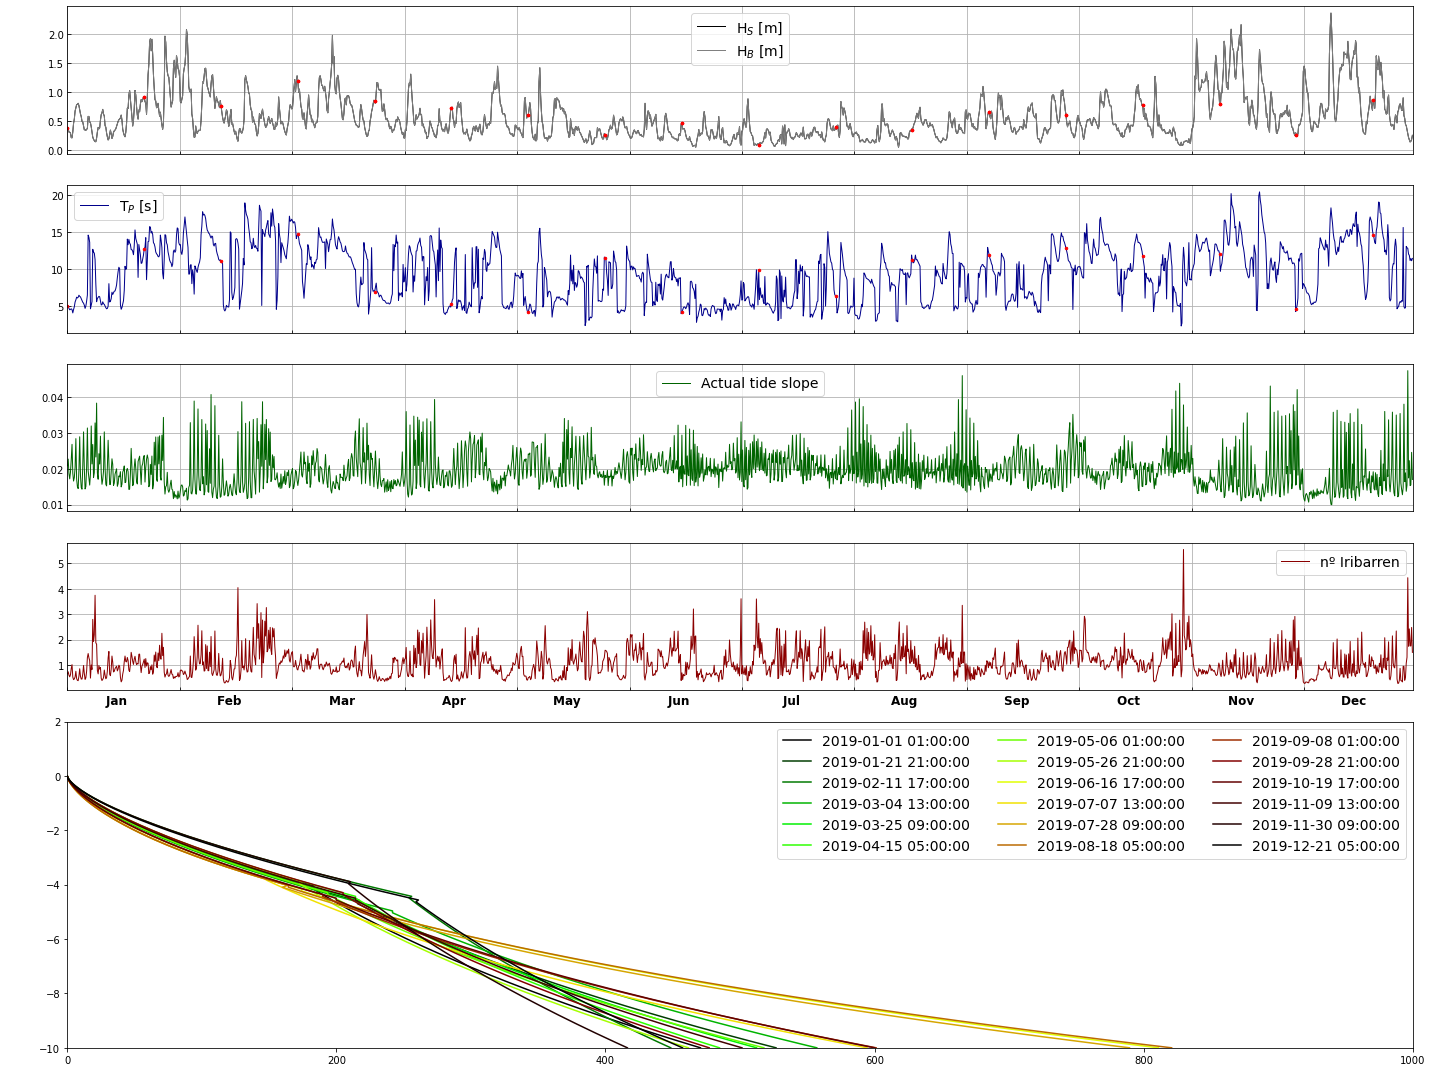

In [20]:
# Select the surfbreak
name = 'forta'
surfbreak = surfbreaks_historic.sel(beach=name).to_dataframe()
delta_angle = 180
wf = 0.015
print('The wf that will be used is: {}'.format(wf))
reconstructed_depth = 6
forta_slope = Slopes(reconstructed_data=surfbreak,
                     tides=tides,
                     delta_angle=delta_angle,
                     wf=wf,
                     name=name,
                     reconstructed_depth=reconstructed_depth)
forta_slope.perform_propagation()
forta_slope.moving_profile(year=2019)
forta_slope.data = index(forta_slope.data)
forta_slope.data['beach'] = name

In [21]:
data = pd.concat([farolillo_slope.data, bederna_slope.data, oyambre_slope.data,
                  locos_slope.data, canallave_slope.data, valdearenas_slope.data, madero_slope.data,
                  segunda_slope.data, primera_slope.data,
                  pueblo_slope.data, curva_slope.data,
                  brusco_slope.data, laredo_slope.data, forta_slope.data])

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1008266 entries, 1979-02-01 02:00:00 to 2020-02-29 20:00:00
Data columns (total 27 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Hs               1008266 non-null  float64
 1   Tp               1008266 non-null  float64
 2   Dir              1008266 non-null  float64
 3   Spr              1008266 non-null  float64
 4   W                1008266 non-null  float64
 5   DirW             1008266 non-null  float64
 6   DDir             1008266 non-null  float64
 7   DDirW            1008266 non-null  float64
 8   ocean_tide       1008266 non-null  float64
 9   Omega            1008266 non-null  float64
 10  H_break          1008266 non-null  float64
 11  DDir_R           1008266 non-null  float64
 12  Slope            1008091 non-null  float64
 13  Iribarren        1008091 non-null  float64
 14  Hb_index         1008266 non-null  float64
 15  Tp_index         1008266 non-null

In [23]:
data.to_pickle(op.join(p_data, 'reconstructed', 'surfbreaks_reconstructed_final.pkl'))